In [1]:
import itertools
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt
import ot 
import os
import seaborn as sns
from sklearn.manifold import MDS

import got 
from logger import Logger

sns.set_style("white")

# 0. Set-Up

In [2]:
DATA_DIR = "results/simulation"
SEED = 50
DPI = 100

In [3]:
# Create the data directory if it doesn't exist
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [4]:
def gw_dist_compute(base_g: nx.Graph, alt_g: nx.Graph): 
    """
    Compute the Gromov-Wasserstein distance between two networkX graphs using the uniform and shortest path cost functions.
    """
    base_got = got.GraphOT(base_g, "uniform", "shortest_path")
    alt_got = got.GraphOT(alt_g, "uniform", "shortest_path")
    T, log = ot.gromov.gromov_wasserstein(base_got.get_cost(), alt_got.get_cost(), 
                                    base_got.get_node_dist(), alt_got.get_node_dist(), log=True, 
                                    random_state = SEED)
    gw_dist = log['gw_dist']
    return gw_dist, T

def show_network(G, y=None, labels=None, pos=None, ax=None, figsize=(5,5)):

    if ax is None:
        plt.figure(figsize=figsize)  # image is 8 x 8 inches
        plt.axis('off')
        ax = plt.gca()

    if pos is None:
        pos = nx.kamada_kawai_layout(G)
        
    nx.draw_networkx_nodes(G, pos, node_size=500, alpha=0.8, node_color=y, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax)
            
    if labels is None:
        nx.draw_networkx_labels(G, pos, font_color='w', font_weight='bold', font_size=15, ax=ax)
    else:
        labeldict = {}
        for i, v in enumerate(G.nodes):
            labeldict[v] = labels[i]
        nx.draw_networkx_labels(G, pos, font_color='w', font_weight='bold', font_size=15, labels=labeldict, ax=ax)

# 1. Pairwise Optimal Transport Plans between Graph Topologies

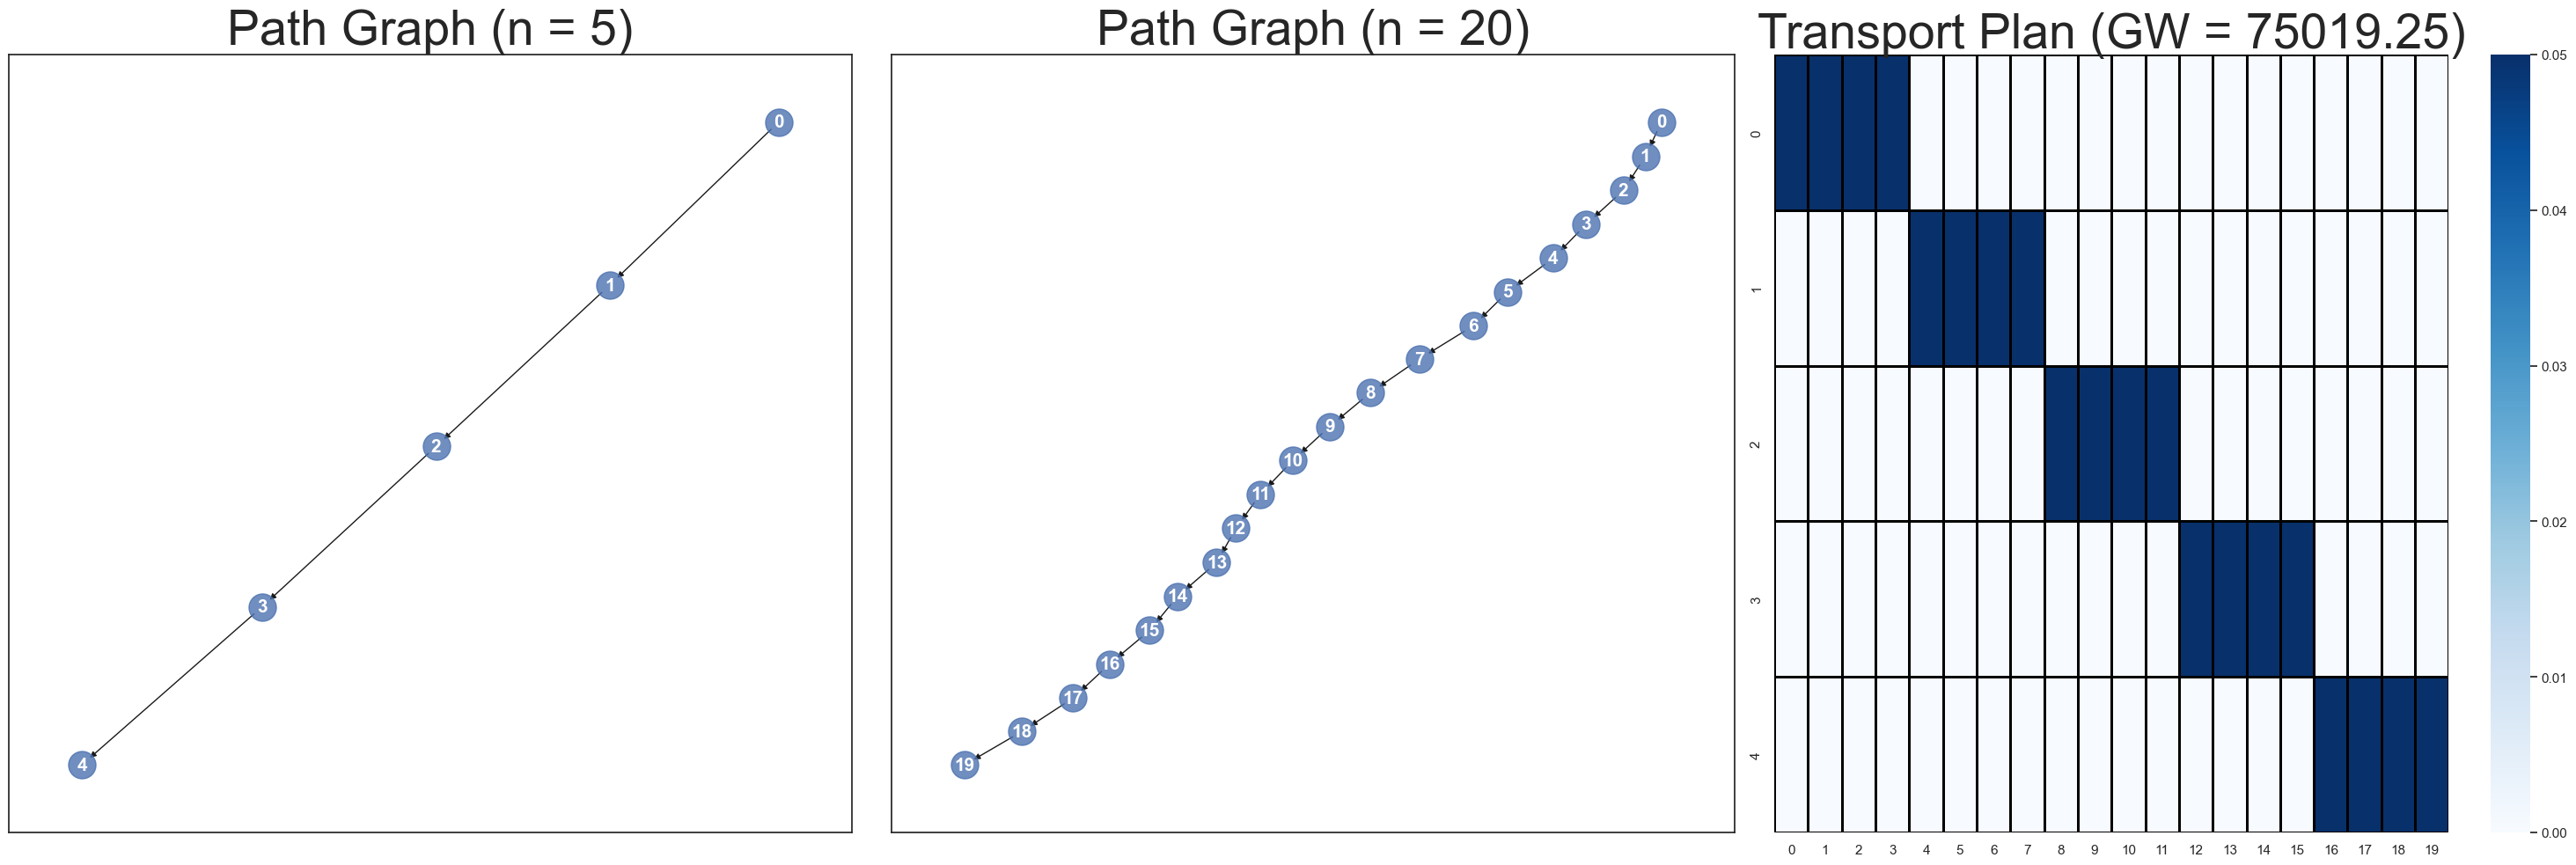

In [5]:
path = nx.path_graph(5, create_using=nx.DiGraph)
path_long = nx.path_graph(20, create_using=nx.DiGraph)
gw_dist, T = gw_dist_compute(path, path_long)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
pos = nx.nx_agraph.graphviz_layout(path, prog="twopi")
show_network(path, ax=ax[0])
show_network(path_long, ax=ax[1])
sns.heatmap(T, cmap="Blues", ax=ax[2], linewidths=1, linecolor='black')

ax[0].set_title("Path Graph (n = 5)", fontsize=40)
ax[1].set_title("Path Graph (n = 20)", fontsize=40)
ax[2].set_title(f"Transport Plan (GW = {gw_dist:.2f})", fontsize=40)
plt.tight_layout()

plt.savefig(f"{DATA_DIR}/path_graph_ot.png", dpi=DPI, bbox_inches='tight')

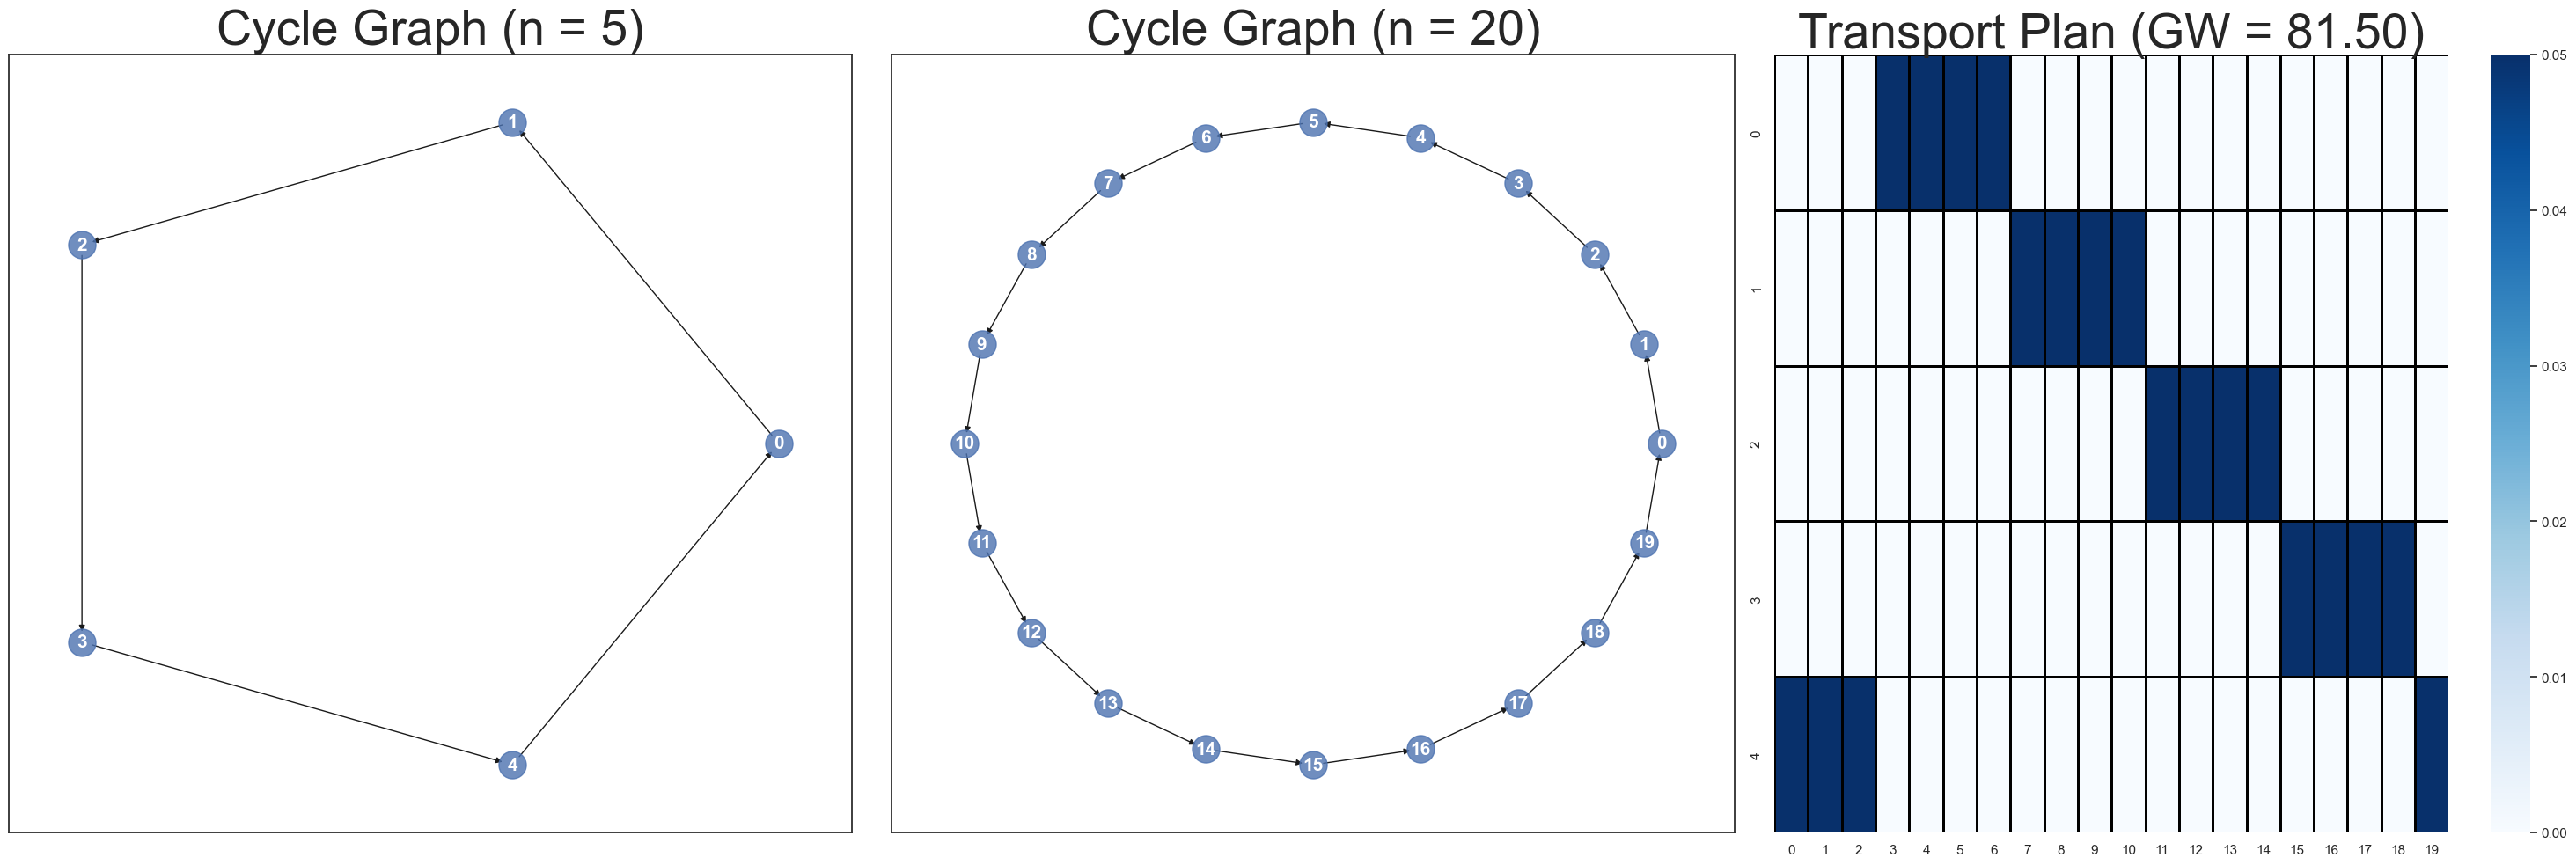

In [6]:
cycle = nx.cycle_graph(5, create_using=nx.DiGraph)
cycle_long = nx.cycle_graph(20, create_using=nx.DiGraph)
gw_dist, T = gw_dist_compute(cycle, cycle_long)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
show_network(cycle, ax=ax[0])
show_network(cycle_long, ax=ax[1])
sns.heatmap(T, cmap="Blues", ax=ax[2], linewidths=1, linecolor='black')

ax[0].set_title("Cycle Graph (n = 5)", fontsize=40)
ax[1].set_title("Cycle Graph (n = 20)", fontsize=40)
ax[2].set_title(f"Transport Plan (GW = {gw_dist:.2f})", fontsize=40)
plt.tight_layout()

plt.savefig(f"{DATA_DIR}/cycle_graph_ot.png", dpi=DPI, bbox_inches='tight')

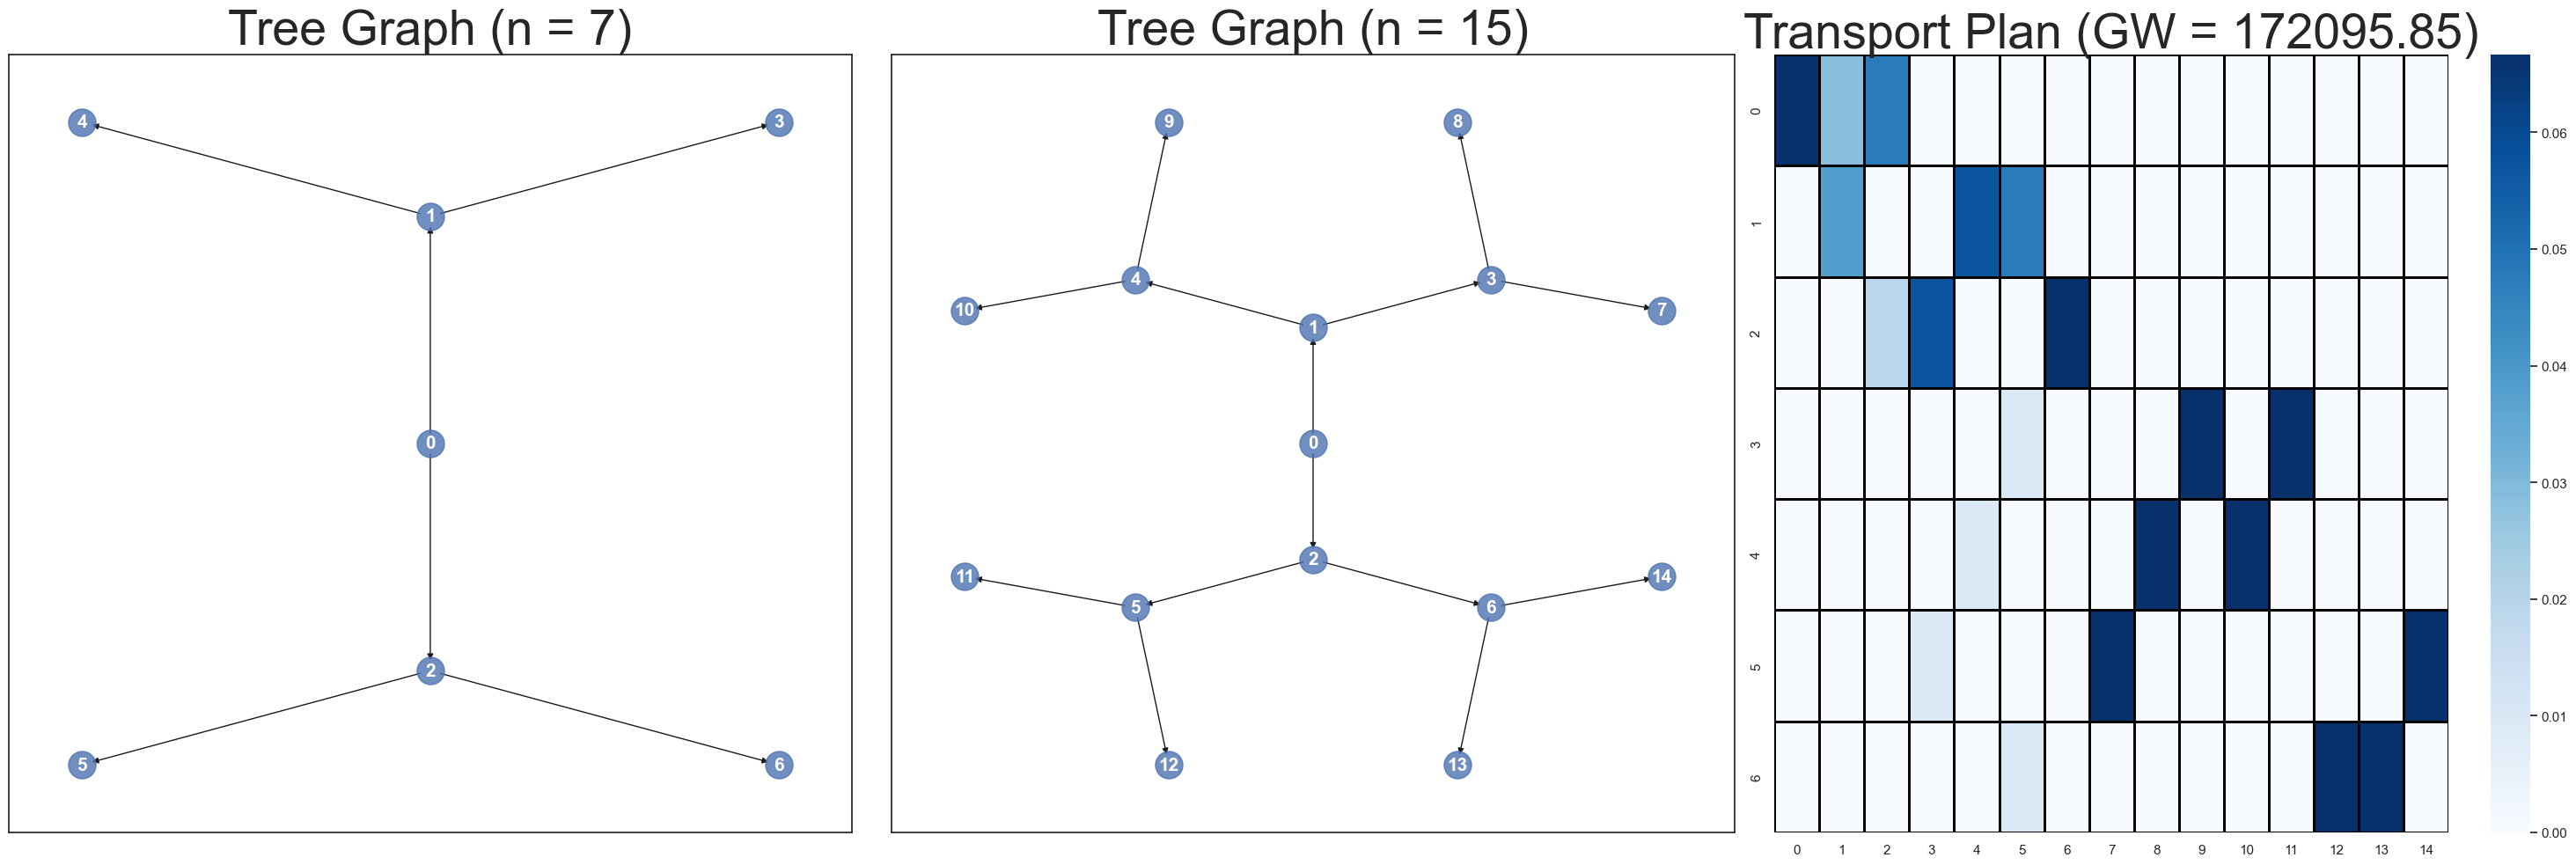

In [7]:
tree = nx.balanced_tree(2, 2, create_using=nx.DiGraph)
tree_long = nx.balanced_tree(2, 3, create_using=nx.DiGraph)
gw_dist, T = gw_dist_compute(tree, tree_long)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
pos = nx.nx_agraph.graphviz_layout(tree, prog="twopi")
show_network(tree, pos=pos, ax=ax[0])
pos = nx.nx_agraph.graphviz_layout(tree_long, prog="twopi")
show_network(tree_long, pos=pos, ax=ax[1])
sns.heatmap(T, cmap="Blues", ax=ax[2], linewidths=1, linecolor='black')

ax[0].set_title("Tree Graph (n = 7)", fontsize=40)
ax[1].set_title("Tree Graph (n = 15)", fontsize=40)
ax[2].set_title(f"Transport Plan (GW = {gw_dist:.2f})", fontsize=40)
plt.tight_layout()

plt.savefig(f"{DATA_DIR}/tree_graph_ot.png", dpi=DPI, bbox_inches='tight')

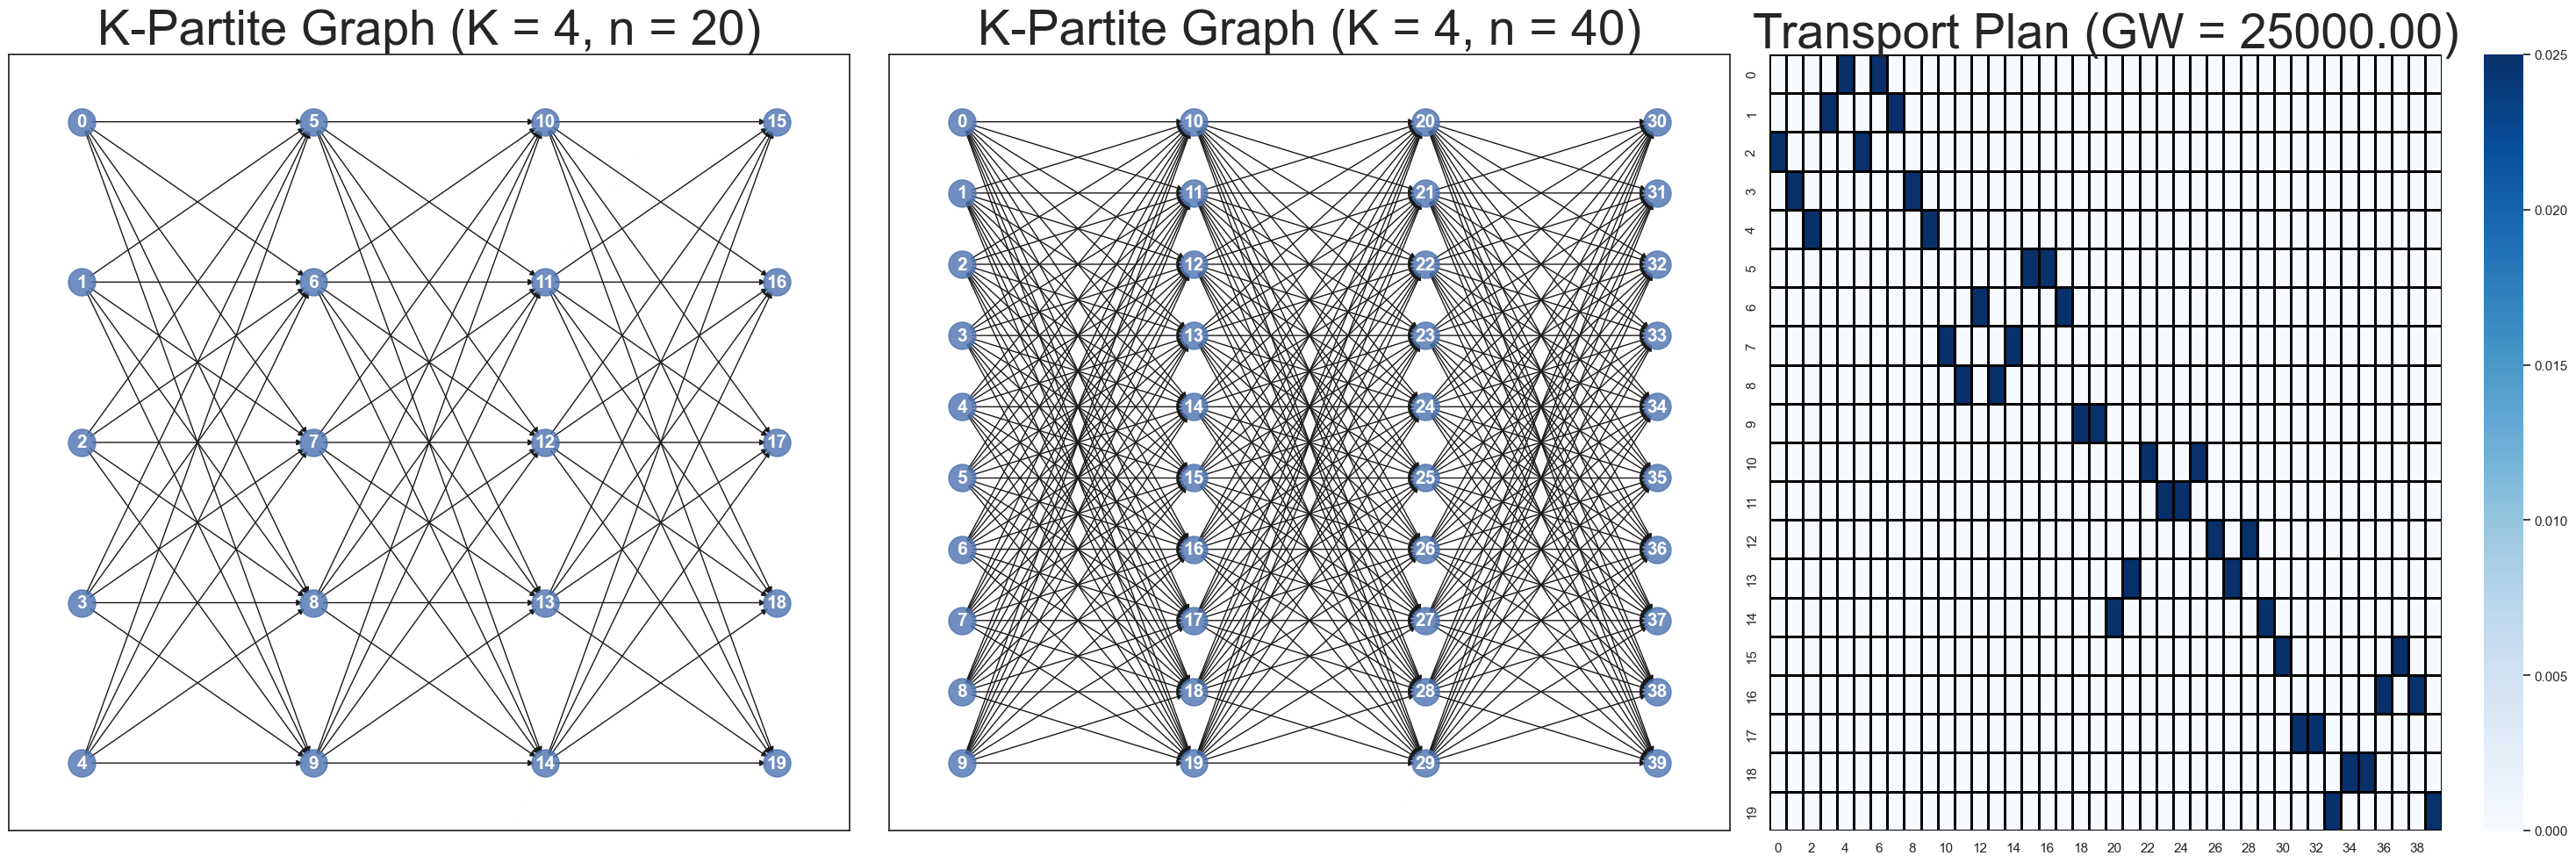

In [8]:
def directed_multilayers(*subset_sizes):
    extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    G = nx.DiGraph()
    for i, layer in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    return G

subset_sizes = [5, 5, 5, 5]
large_subset_sizes = [10, 10, 10, 10]
subset_color = [
    "gold",
    "blue",
    "red",
    "red"
]

k_par = directed_multilayers(*subset_sizes)
k_par_large = directed_multilayers(*large_subset_sizes)
gw_dist, T = gw_dist_compute(k_par, k_par_large)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
G = k_par
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
show_network(G, pos=pos, ax=ax[0])

G = k_par_large
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
show_network(G, pos=pos, ax=ax[1])

sns.heatmap(T, cmap="Blues", ax=ax[2], linewidths=1, linecolor='black')

ax[0].set_title("K-Partite Graph (K = 4, n = 20)", fontsize=40)
ax[1].set_title("K-Partite Graph (K = 4, n = 40)", fontsize=40)
ax[2].set_title(f"Transport Plan (GW = {gw_dist:.2f})", fontsize=40)
plt.tight_layout()

plt.savefig(f"{DATA_DIR}/k_partite_graph_ot.png", dpi=DPI, bbox_inches='tight')

# 2. Block Graphs

In [9]:
def add_block(g, node_id, block_size=4):
    """ 
    Create a block in graph G surrounding node_id 
    """ 
    # make a copy to not operate on the original
    g = nx.Graph(g)
    n = len(g)
    for i in range(block_size): 
        g.add_node(n+i)
    # make the newly added nodes fully connected
    for i in range(block_size):
        for j in range(i+1, block_size):
            g.add_edge(n+i, n+j)
    # connect the new nodes to the existing graph by replacing the edges from node ID to the broader 
    # graph with edges to the community of the new nodes 
    nodes_to_patch = []
    original_edges = list(g.edges(node_id))
    for edge in original_edges:
        # remove edges originally connected to node_id
        g.remove_edge(edge[0], edge[1])
        # document the node that we need to establish a connection back to
        nodes_to_patch.append(edge[1]) if edge[1] != node_id else nodes_to_patch.append(edge[0])
    patch_order = [n + i for i in range(block_size)]
    for node in nodes_to_patch: 
        g.add_edge(node, patch_order.pop(0))
    # delete the node that we removed 
    g.remove_node(node_id) 
    g = nx.relabel_nodes(g, {n + block_size - 1: node_id})
    return g 

def construct_block_model(model_generator, n, k, block_size=4, n_2 = None): 
    if n_2 is not None: 
        g = model_generator(n, n_2)
    else: 
        g = model_generator(n)
    for i in range(k):
        g = add_block(g, i, block_size=block_size)
    node_mapping = {label: idx for idx, label in enumerate(list(g.nodes()))}
    g = nx.relabel_nodes(g, node_mapping)
    return g 

# set up the base graphs 
base_star = nx.star_graph(4)
base_path = nx.path_graph(5)
base_cycle = nx.cycle_graph(5)
base_tree = nx.balanced_tree(2, 2)

# set up the 4-block graphs 
block_star = construct_block_model(nx.star_graph, 4, 5, 4)
block_path = construct_block_model(nx.path_graph, 5, 5, 4)
block_cycle = construct_block_model(nx.cycle_graph, 5, 5, 4)
block_tree = construct_block_model(nx.balanced_tree, 2, 7, 4, n_2 = 2)

# compute the Gromov-Wasserstein distance between the base and block graphs
star_gw, star_T = gw_dist_compute(base_star, block_star)
path_gw, path_T = gw_dist_compute(base_path, block_path)
cycle_gw, cycle_T = gw_dist_compute(base_cycle, block_cycle)
tree_gw, tree_T = gw_dist_compute(base_tree, block_tree)

In [10]:
def vis_block_graph(base_G: nx.Graph, block_G: nx.Graph, block_name: str, gw_dist: float, T): 
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    show_network(base_G, ax=ax[0])
    show_network(block_G, ax=ax[1])
    sns.heatmap(T, cmap="Blues", ax=ax[2], linewidths=1, linecolor='black')

    ax[0].set_title(f"{block_name} Graph (n = 5)", fontsize=40)
    ax[1].set_title(f"{block_name} Block Graph (n = 20)", fontsize=40)
    ax[2].set_title(f"Transport Plan (GW = {gw_dist:.2f})", fontsize=40)
    plt.tight_layout()

    plt.savefig(f"{DATA_DIR}/{block_name}_block_graph_ot.png", dpi=DPI, bbox_inches='tight')


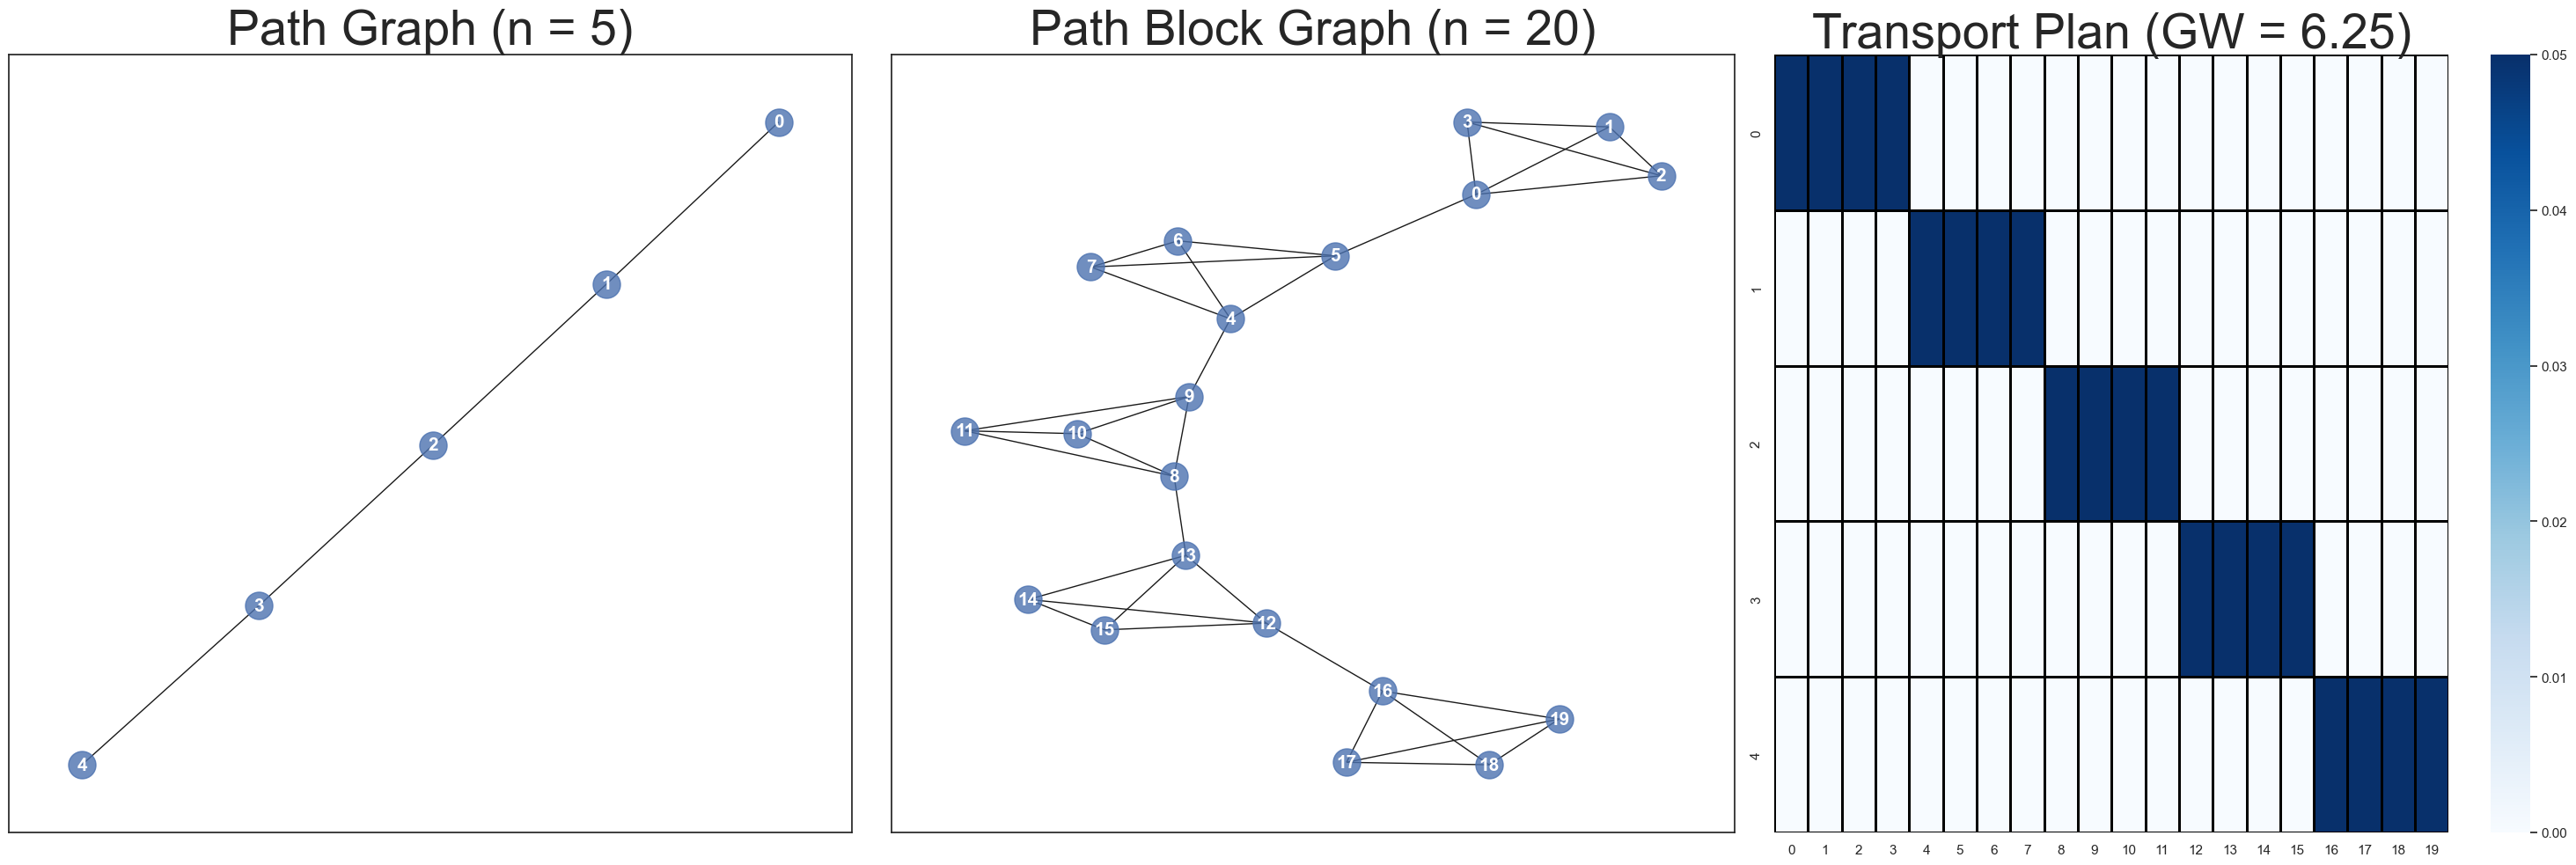

In [11]:
vis_block_graph(base_path, block_path, "Path", path_gw, path_T)

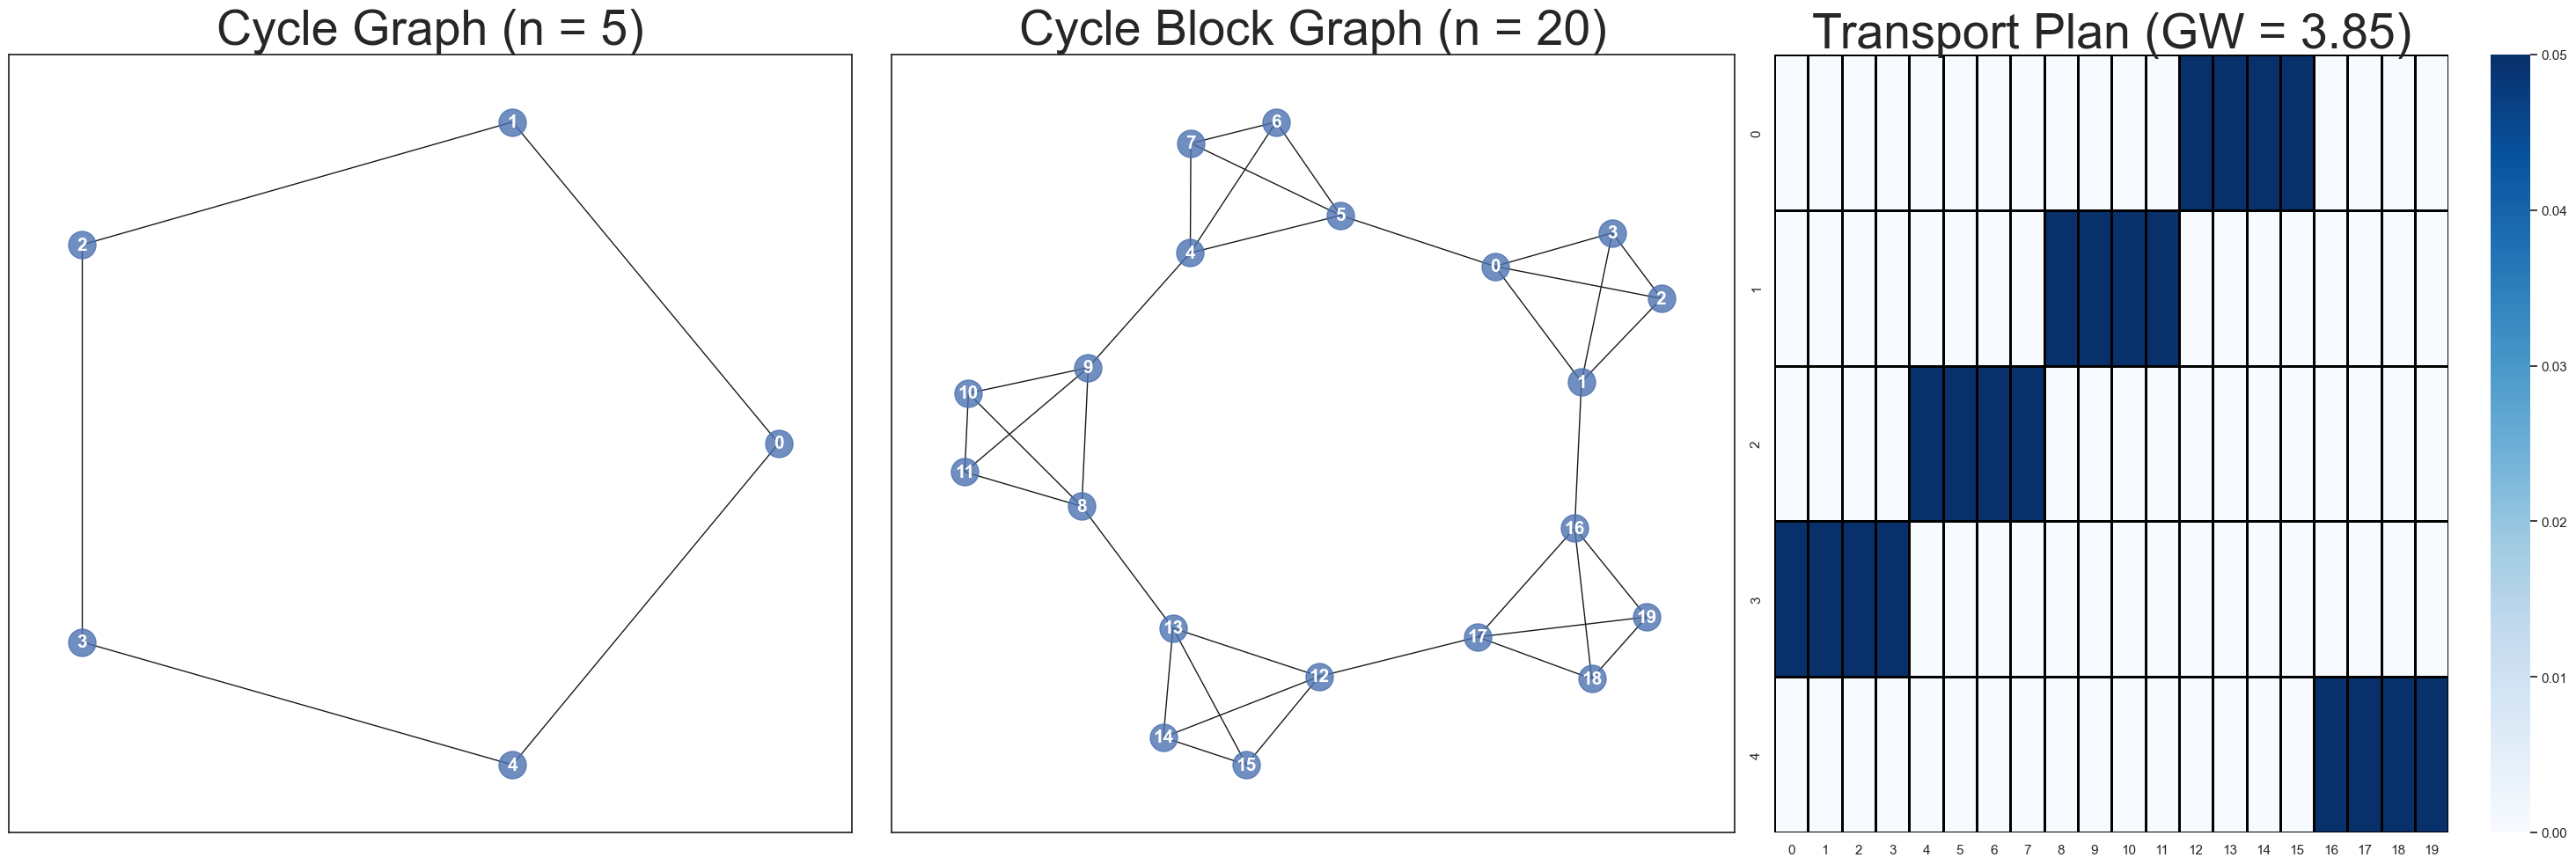

In [12]:
vis_block_graph(base_cycle, block_cycle, "Cycle", cycle_gw, cycle_T)

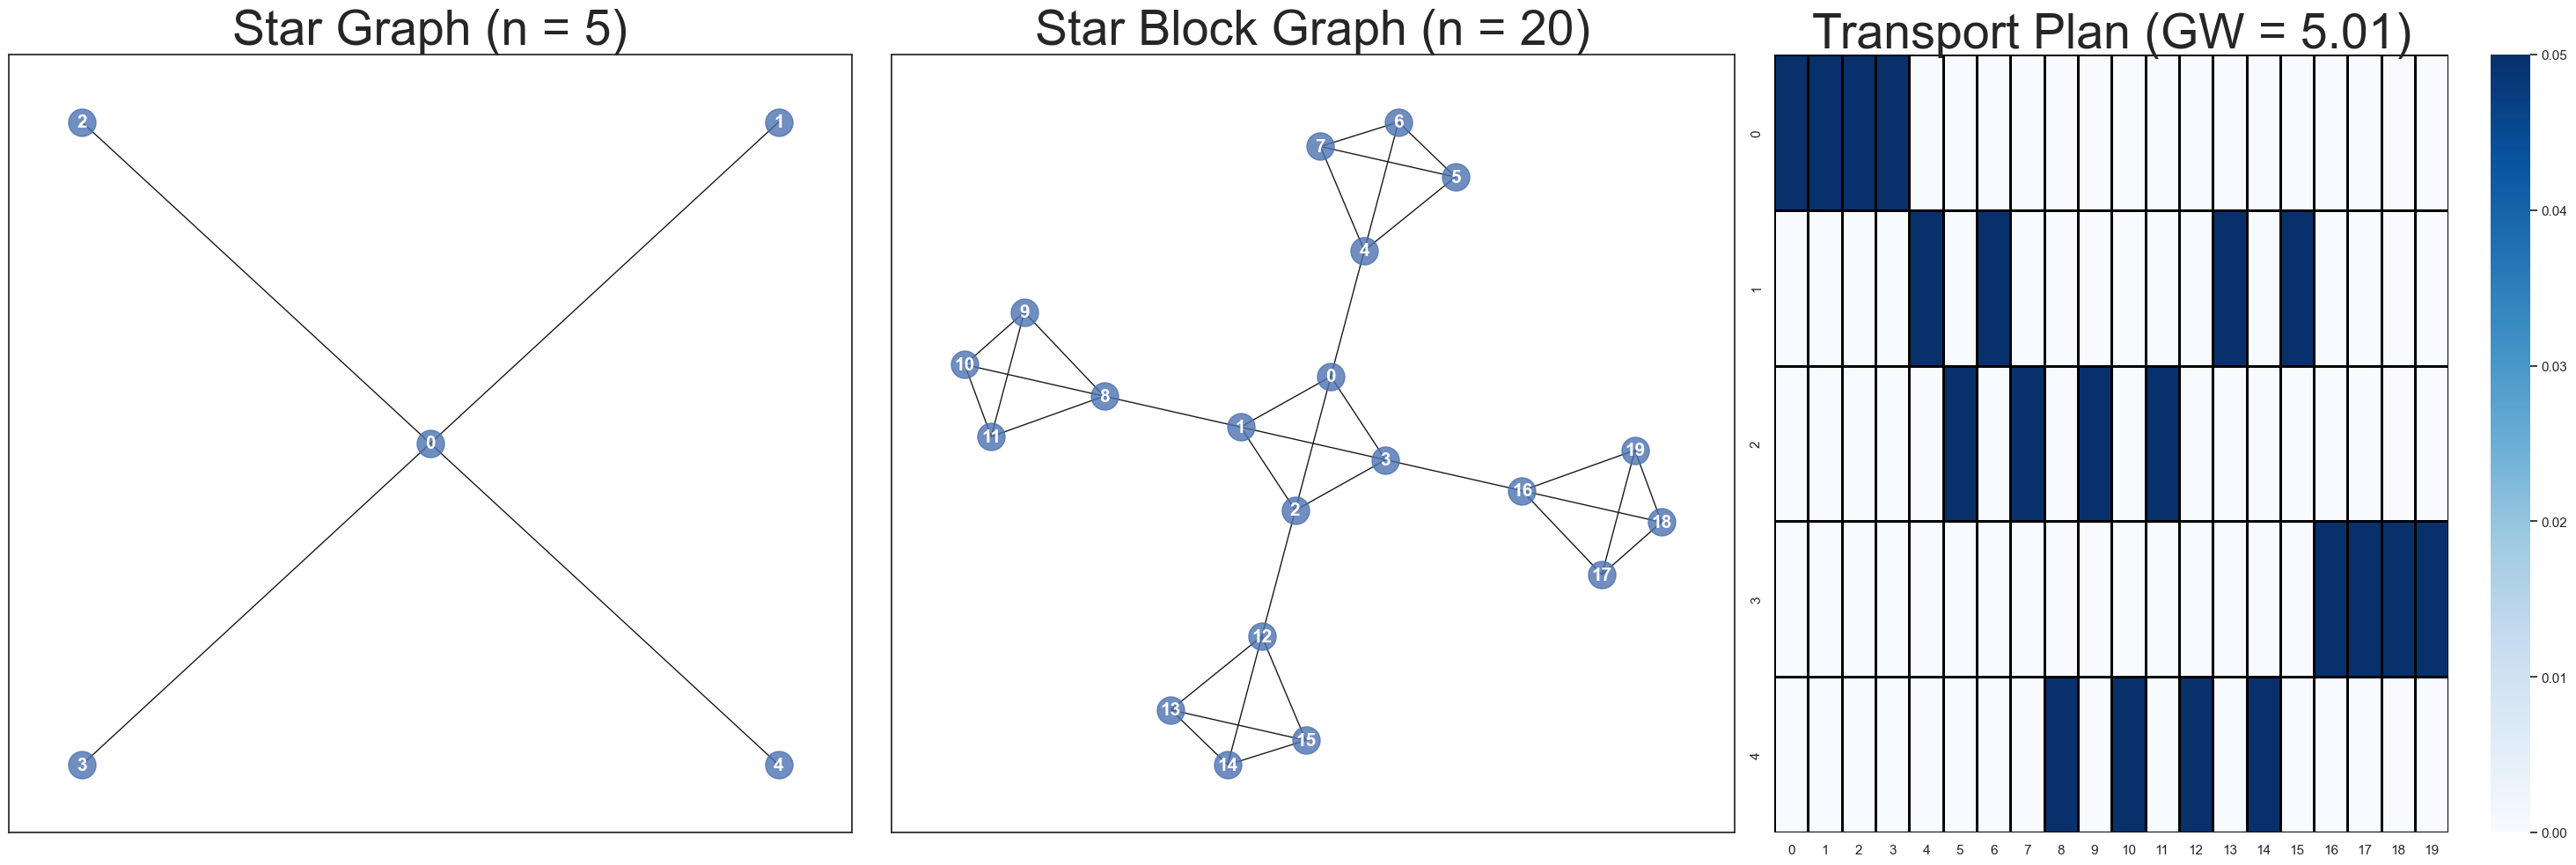

In [13]:
vis_block_graph(base_star, block_star, "Star", star_gw, star_T)

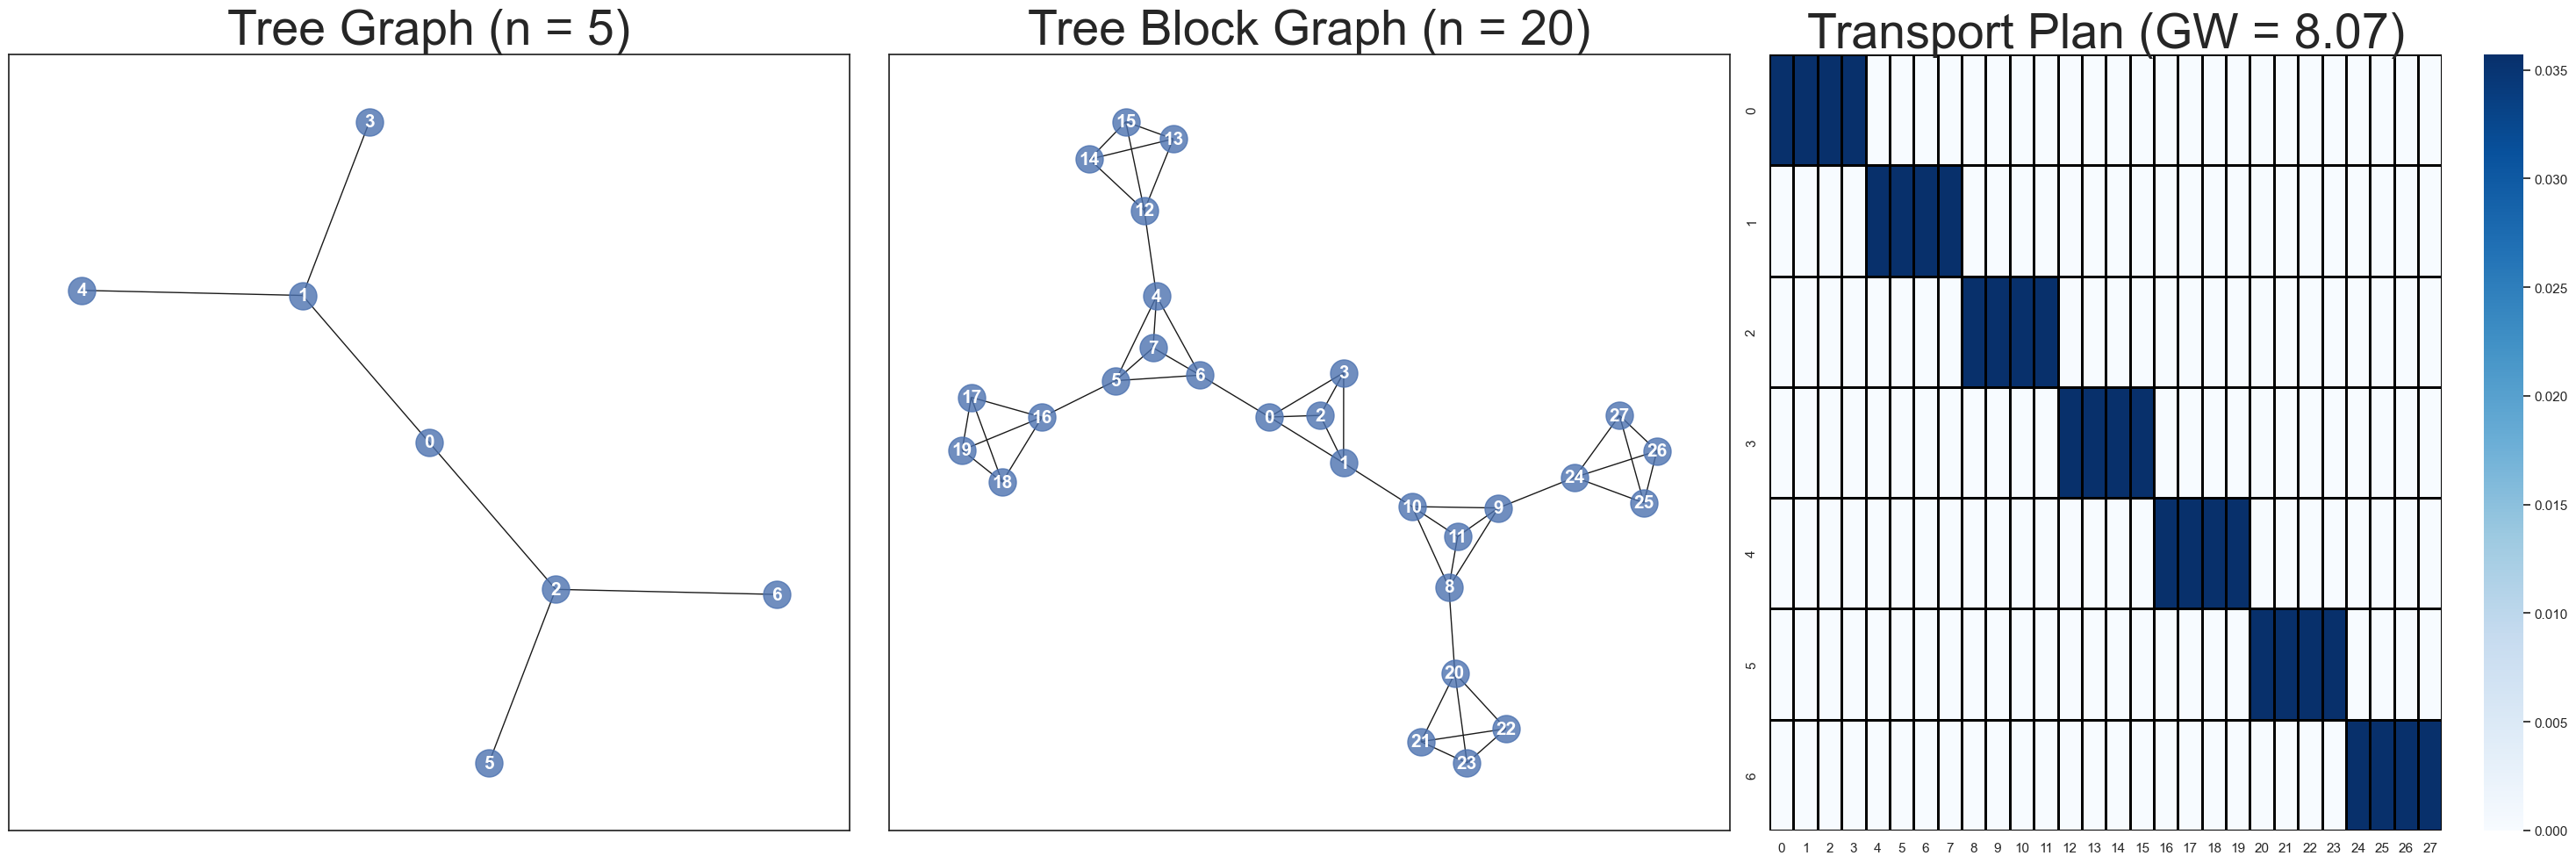

In [14]:
vis_block_graph(base_tree, block_tree, "Tree", tree_gw, tree_T)

The following code snippet for executing the MDS block graph experiment is a test for the real thing (note that SAMPLES = 5). For the actual experiment ran in the paper, set SAMPLES to 5. This will end up taking a while -- roughly 28 minutes. 

In [15]:
SAMPLES = 5 
BASE_NODES = 5
NODE_DIST = "uniform"
COST_METHOD = "shortest_path"

np.random.seed(SEED)
# generate random block sizes
BLOCK_SIZE = np.random.randint(5, 70, SAMPLES)

# generate block graphs for paths, cycles and stars
paths = [construct_block_model(nx.path_graph, BASE_NODES, BASE_NODES, BLOCK_SIZE[i]) for i in range(SAMPLES)]
cycles = [construct_block_model(nx.cycle_graph, BASE_NODES, BASE_NODES, BLOCK_SIZE[i]) for i in range(SAMPLES)]
stars = [construct_block_model(nx.star_graph, BASE_NODES - 1, BASE_NODES, BLOCK_SIZE[i]) for i in range(SAMPLES)]
trees = [construct_block_model(nx.balanced_tree, 2, 7, BLOCK_SIZE[i], n_2 = 2) for i in range(SAMPLES)]

# join the graphs into a single dictionary
block_graphs = {}
for i in range(SAMPLES): 
    block_graphs[i] = paths[i]
    block_graphs[i + SAMPLES] = cycles[i]
    block_graphs[i + 2*SAMPLES] = stars[i]
    block_graphs[i + 3*SAMPLES] = trees[i]

# generate the block graphs for the GOT dataset
block_factory = got.GraphOT_Factory(block_graphs, NODE_DIST, COST_METHOD)

# compute the pairwise distance matrices for the block graphs
block_gw, block_T = block_factory.compute_pairwise_mat()


Computing pairwise distance...


 90%|█████████ | 90/100 [00:06<00:00, 14.95it/s]


In [16]:
l = Logger(DATA_DIR + "/mds_vis", "block-Path-Cycle-Star-Tree") 
params = {
    "seed": SEED,
    "samples": SAMPLES,
    "base_nodes": BASE_NODES,
    "node_dist": NODE_DIST,
    "cost_method": COST_METHOD,
    "block_sizes": BLOCK_SIZE, 
    "block_gw": block_gw,
}
l.log_params(params)

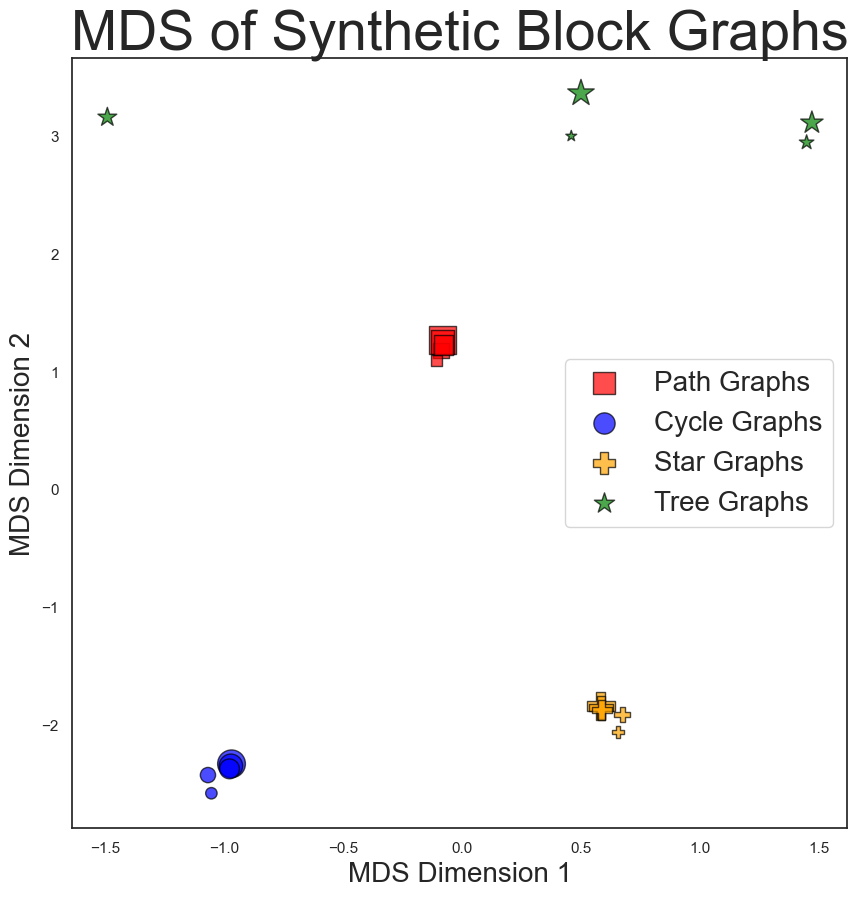

In [17]:
# Plot the MDS of the GW distance matrix
np.random.seed(SEED)
mds = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto')
mds_transformed = mds.fit_transform(block_gw)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# plot scatter plot points scaled to size of the block size
scaled_block_size = BLOCK_SIZE / np.max(BLOCK_SIZE) * 400 # scales to 0-4 sized markers 
ax.scatter(mds_transformed[:SAMPLES, 0], mds_transformed[:SAMPLES, 1], 
           label='Path Graphs', c='red', marker='s', s=scaled_block_size, edgecolor='black', alpha=0.7)
ax.scatter(mds_transformed[SAMPLES:2*SAMPLES, 0], mds_transformed[SAMPLES:2*SAMPLES, 1], 
           label='Cycle Graphs', c='blue', marker='o', s=scaled_block_size, edgecolor='black', alpha=0.7)
ax.scatter(mds_transformed[2*SAMPLES:3*SAMPLES, 0], mds_transformed[2*SAMPLES:3*SAMPLES, 1], 
           label='Star Graphs', c='orange', marker='P', s=scaled_block_size, edgecolor='black', alpha=0.7)
ax.scatter(mds_transformed[3*SAMPLES:, 0], mds_transformed[3*SAMPLES:, 1], 
           label='Tree Graphs', c='green', marker='*', s=scaled_block_size, edgecolor='black', alpha=0.7)
ax.legend(fontsize = 20)
ax.set_title('MDS of Synthetic Block Graphs', fontsize=40)
# add axis labels
ax.set_xlabel('MDS Dimension 1', fontsize=20)
ax.set_ylabel('MDS Dimension 2', fontsize=20)
plt.savefig(l.get_exp_folder_path() + "MDS_Synthetic_Blocks.png", dpi=DPI, bbox_inches='tight')
plt.savefig(DATA_DIR + "/mds_synthetic_blocks.png", dpi=DPI, bbox_inches='tight')

# 3. Cascade Model Simulations

In [18]:
GENERATIVE_RES_DIR = "results/simulation/generative"

if not os.path.exists(GENERATIVE_RES_DIR):
    os.makedirs(GENERATIVE_RES_DIR)

In [19]:
def cascade_graph(S, C):
    """
    A method to generate a food web following the method defined in 
    "Simple rules yield complex food webs" for the Cascade method.

    Inputs: 
    - S: int, the number of species in our food web
    - C: float, the directed connectance of our food web, total number of realized links over the total number of possible links (L/S^2)

    Outputs:
    - G: A networkx object which represents our food web
    """
    values = np.random.uniform(0, 1, S)
    pecking_order = np.sort(values)
    prob_of_consumption = (2 * C * S) / (S - 1)
    adj_mat = np.zeros((S, S))
    for i in range(S):
        for j in range(i):
            candidate = np.random.uniform(0, 1)
            if candidate <= prob_of_consumption:
                adj_mat[i,j] = 1
    G = nx.from_numpy_array(adj_mat, create_using=nx.DiGraph)
    #disconnected_nodes = []
    #for k in range(S):
    #    if adj_mat[i, :] == np.zeros(S) and adj_mat[:,i] == np.zeros(S):
    #        disconnected_nodes.append(i)
    #for node in disconnected_nodes:
        # cascade_fix(S, C, pecking_order, prob_of_consumption, adj_mat
    # if not nx.is_weakly_connected(G):
        # print("Food Web is not Weakly Connected")
    return G

In [20]:
cascade_01 = cascade_graph(15, 0.1)
cascade_02 = cascade_graph(15, 0.2)
cascade_03 = cascade_graph(15, 0.3)
cascade_04 = cascade_graph(15, 0.4)

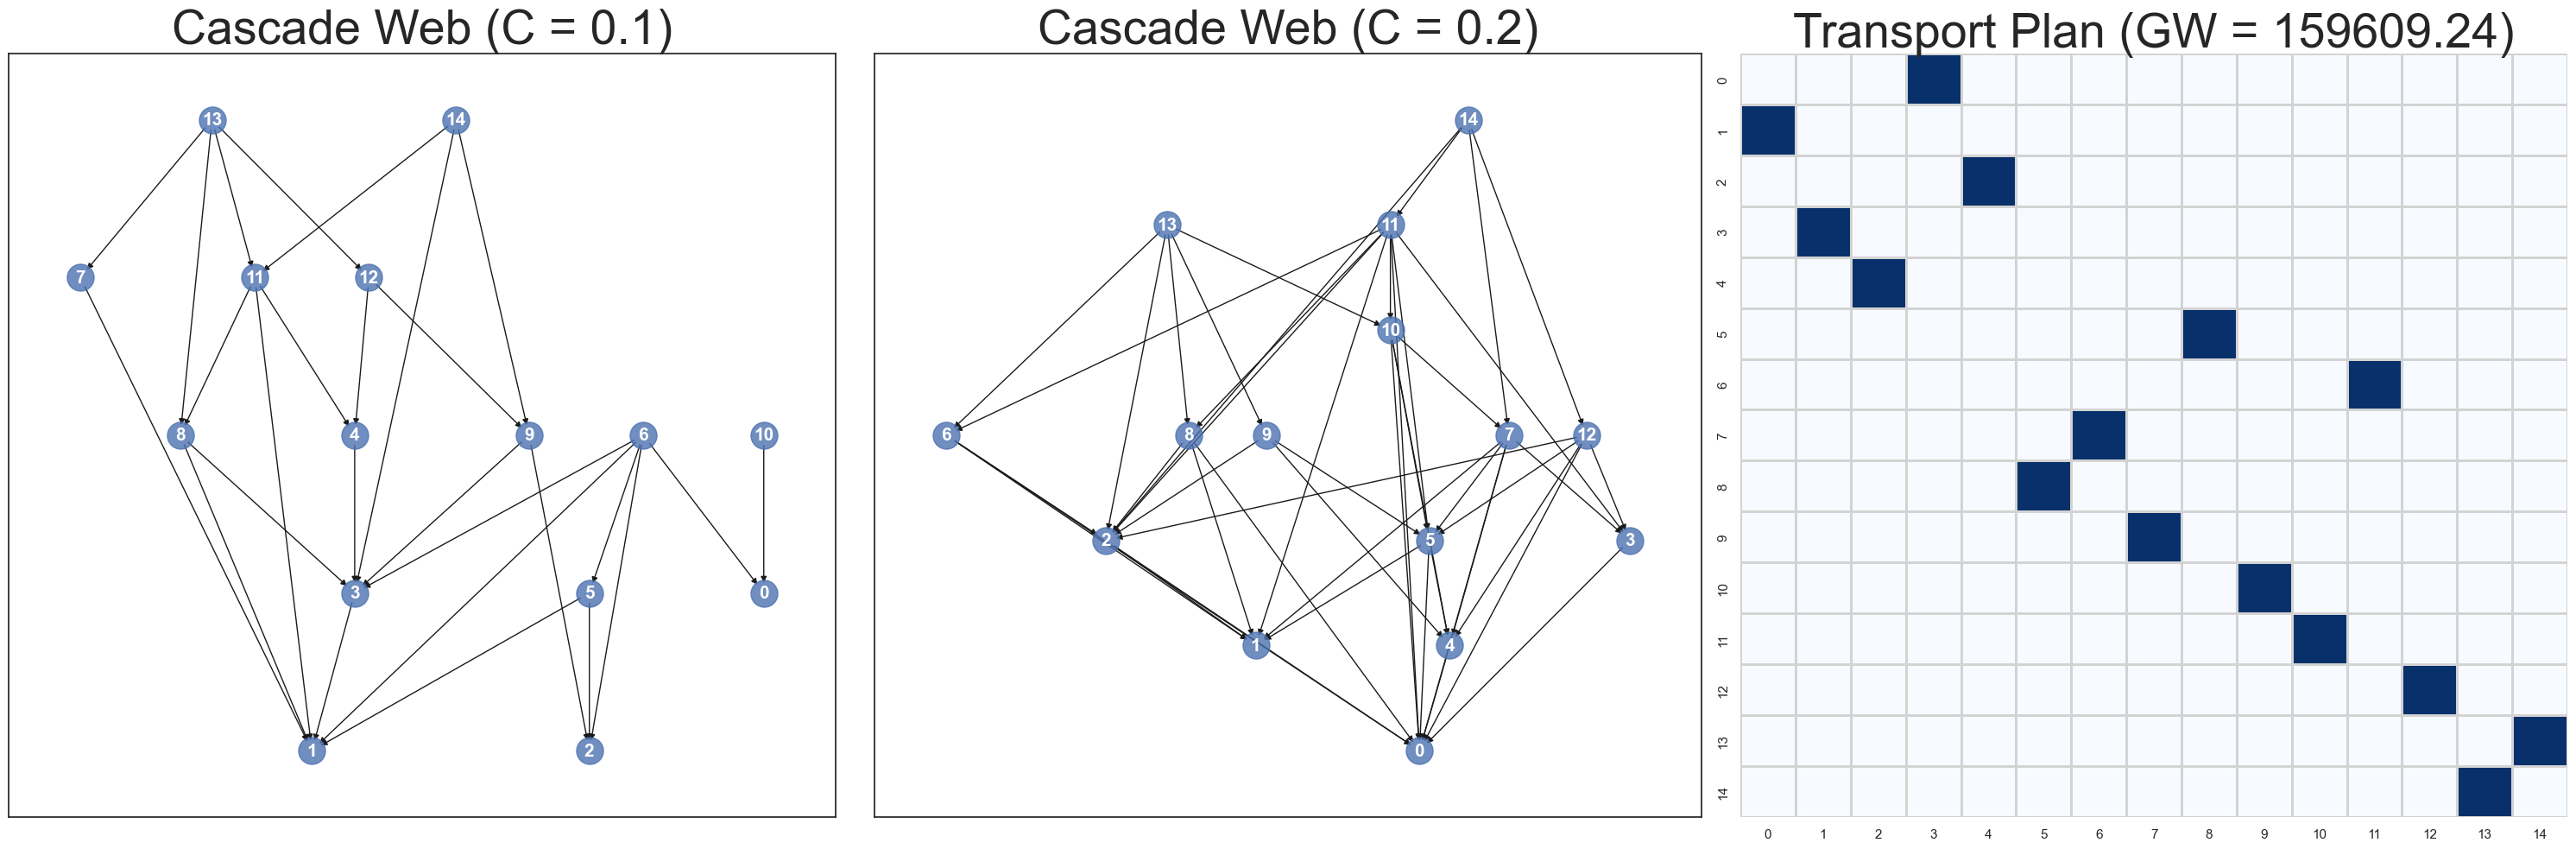

In [21]:
gw_dist, T = gw_dist_compute(cascade_01, cascade_02)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
pos1 = nx.nx_agraph.graphviz_layout(cascade_01, prog="dot")
pos2 = nx.nx_agraph.graphviz_layout(cascade_02, prog="dot")
show_network(cascade_01, ax=ax[0], pos = pos1)
show_network(cascade_02, ax=ax[1], pos = pos2)
sns.heatmap(T, cmap="Blues", ax=ax[2], linewidths=1, linecolor='lightgray', cbar=False)

ax[0].set_title("Cascade Web (C = 0.1)", fontsize=40)
ax[1].set_title("Cascade Web (C = 0.2)", fontsize=40)
ax[2].set_title(f"Transport Plan (GW = {gw_dist:.2f})", fontsize=40)
plt.tight_layout()

plt.savefig(f"{GENERATIVE_RES_DIR}/cascade_graph_1.png", dpi=DPI, bbox_inches='tight')

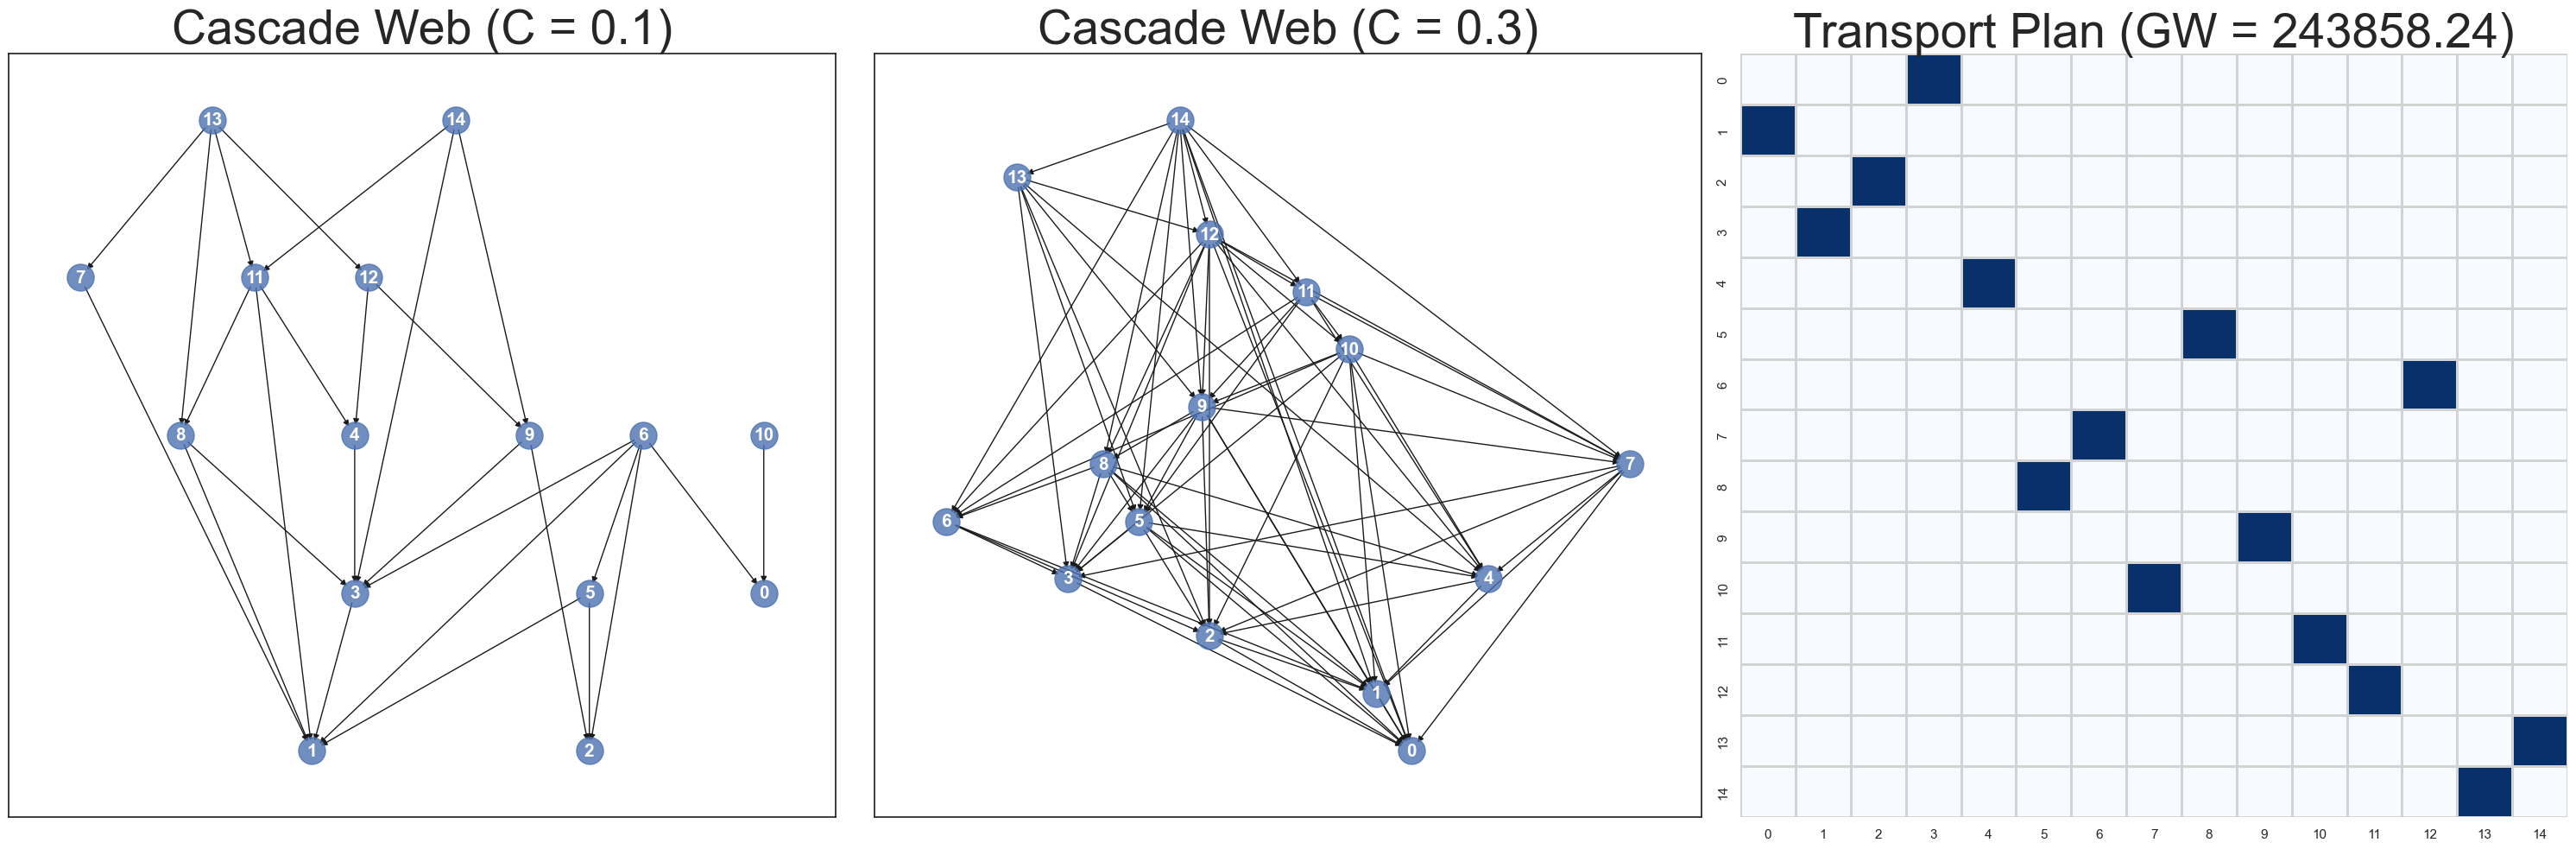

In [22]:
gw_dist, T = gw_dist_compute(cascade_01, cascade_03)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
pos1 = nx.nx_agraph.graphviz_layout(cascade_01, prog="dot")
pos2 = nx.nx_agraph.graphviz_layout(cascade_03, prog="dot")
show_network(cascade_01, ax=ax[0], pos = pos1)
show_network(cascade_03, ax=ax[1], pos = pos2)
sns.heatmap(T, cmap="Blues", ax=ax[2], linewidths=1, linecolor='lightgray', cbar=False)

ax[0].set_title("Cascade Web (C = 0.1)", fontsize=40)
ax[1].set_title("Cascade Web (C = 0.3)", fontsize=40)
ax[2].set_title(f"Transport Plan (GW = {gw_dist:.2f})", fontsize=40)
plt.tight_layout()

plt.savefig(f"{GENERATIVE_RES_DIR}/cascade_graph_2.png", dpi=DPI, bbox_inches='tight')

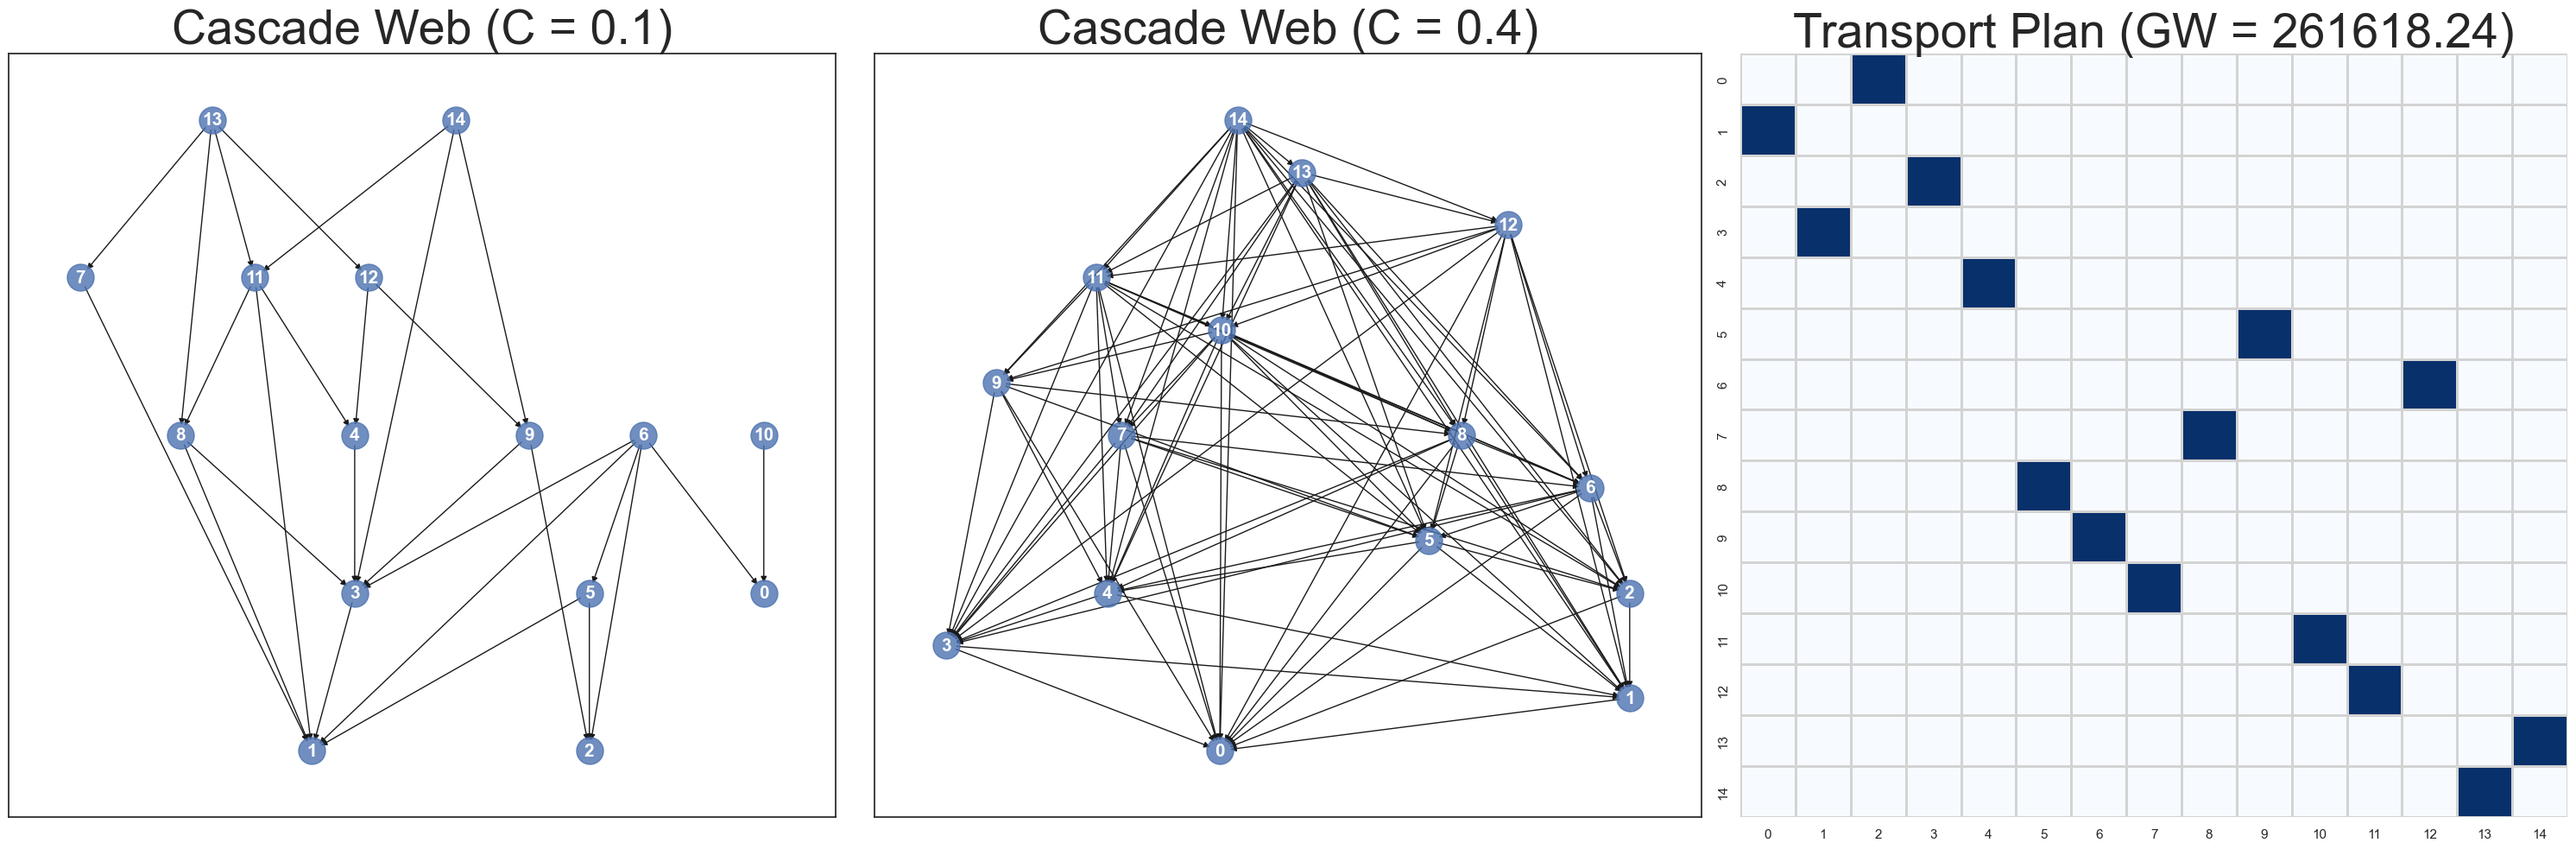

In [23]:
gw_dist, T = gw_dist_compute(cascade_01, cascade_04)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
pos1 = nx.nx_agraph.graphviz_layout(cascade_01, prog="dot")
pos2 = nx.nx_agraph.graphviz_layout(cascade_04, prog="dot")
show_network(cascade_01, ax=ax[0], pos = pos1)
show_network(cascade_04, ax=ax[1], pos = pos2)
sns.heatmap(T, cmap="Blues", ax=ax[2], linewidths=1, linecolor='lightgray', cbar=False)

ax[0].set_title("Cascade Web (C = 0.1)", fontsize=40)
ax[1].set_title("Cascade Web (C = 0.4)", fontsize=40)
ax[2].set_title(f"Transport Plan (GW = {gw_dist:.2f})", fontsize=40)
plt.tight_layout()

plt.savefig(f"{GENERATIVE_RES_DIR}/cascade_graph_3.png", dpi=DPI, bbox_inches='tight')

# 4. Niche Model Simulations

In [24]:
def niche_graph(S, C):
    """
    A method to generate a food web following the method defined in 
    "Simple rules yield complex food webs" for the Niche method.

    Inputs: 
    - S: int, the number of species in our food web
    - C: float, the directed connectance of our food web, total number of realized links over the total number of possible links (L/S^2)

    Outputs:
    - G: A networkx object which represents our food web
    """
    values = np.random.uniform(0, 1, S)
    n = np.sort(values)
    betas = np.random.beta(1, (1 / (2 *C)) - 1, S)
    r = np.multiply(n, betas)
    adj_mat = np.zeros((S, S))
    for i in range(S):
        center = np.random.uniform(r[i] / 2, n[i])
        for j in range(S):
            if center - (r[i] / 2) <= n[j] <= center + (r[i] / 2):
                adj_mat[i][j] = 1
    G = nx.from_numpy_array(adj_mat, create_using=nx.DiGraph)
    # if not nx.is_weakly_connected(G):
        # print("Food Web is not Weakly Connected")
    return G

In [25]:
niche_01 = niche_graph(15, 0.1)
niche_02 = niche_graph(15, 0.2)
niche_03 = niche_graph(15, 0.3)
niche_04 = niche_graph(15, 0.4)

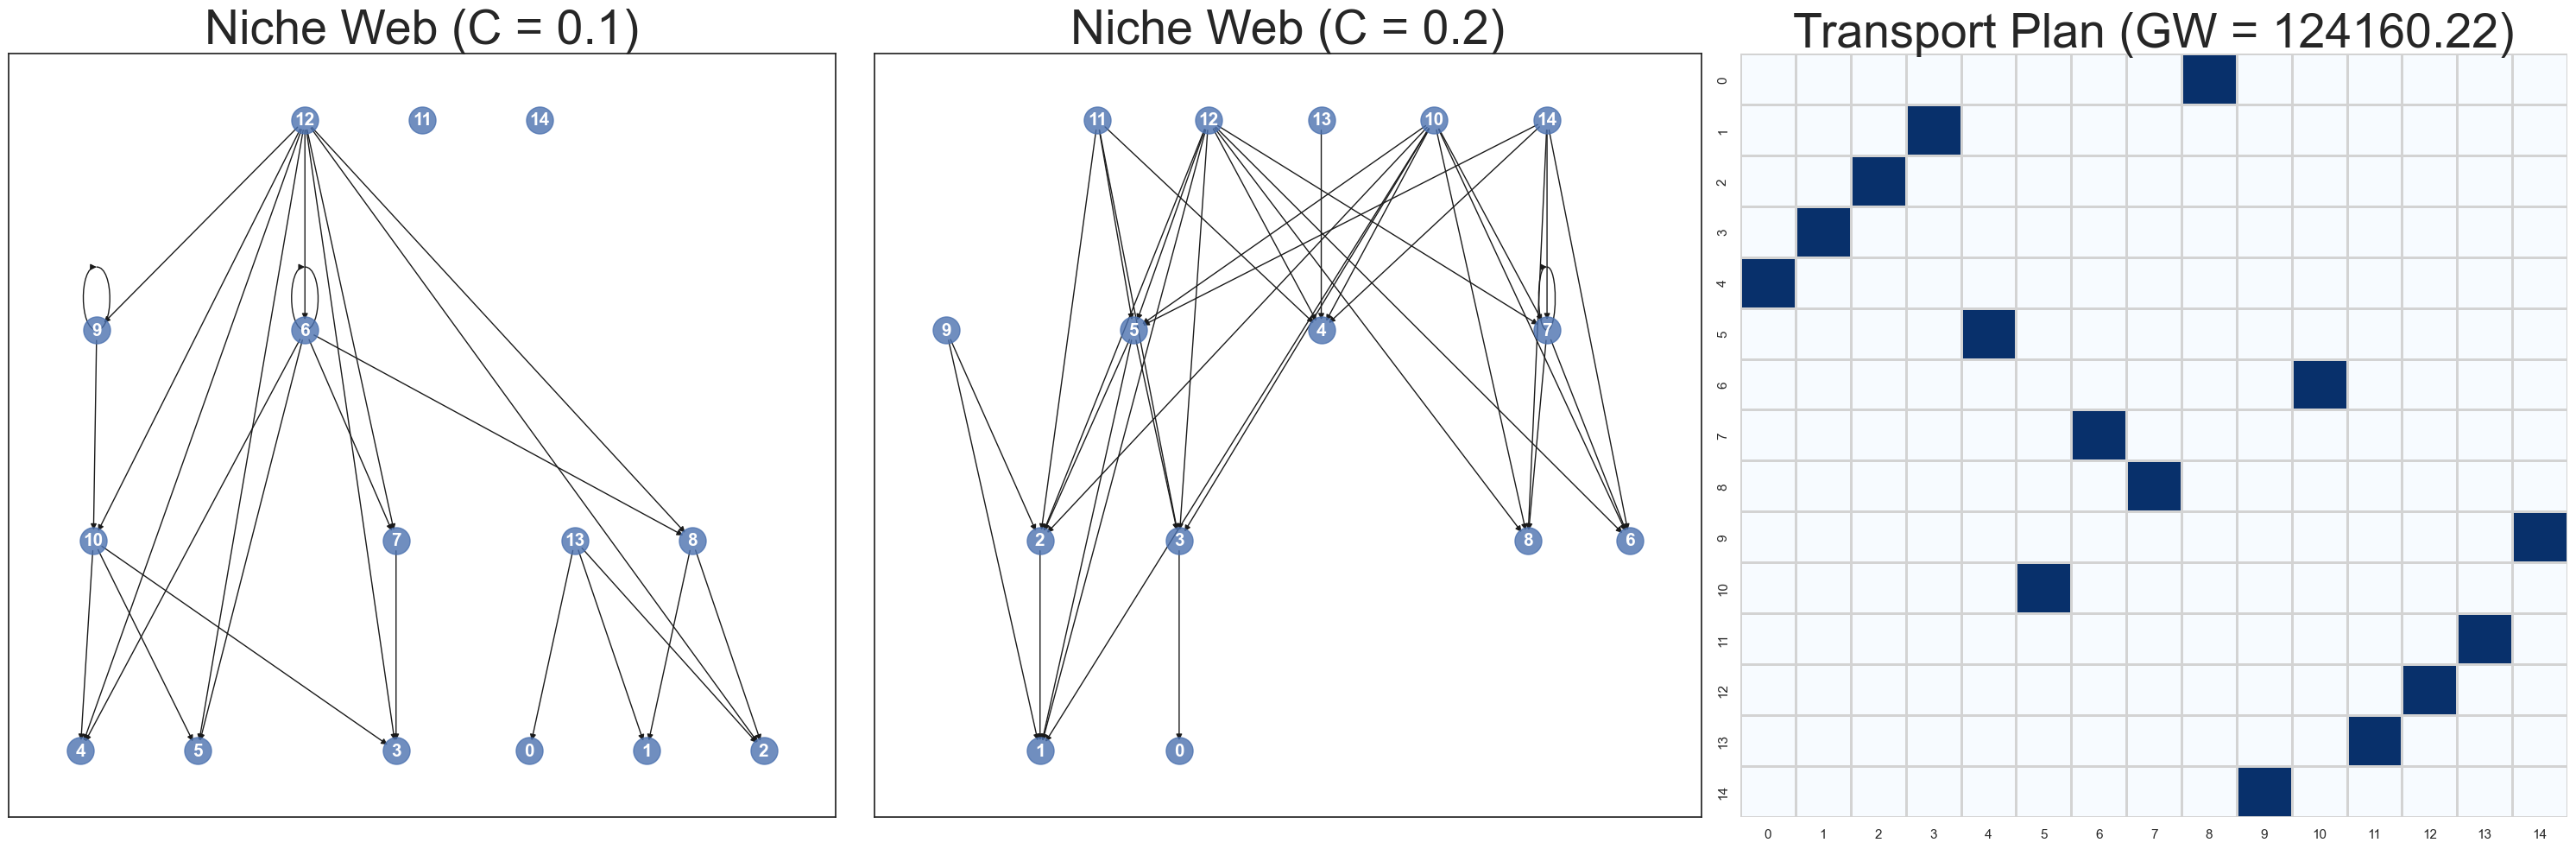

In [26]:
gw_dist, T = gw_dist_compute(niche_01, niche_02)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
pos1 = nx.nx_agraph.graphviz_layout(niche_01, prog="dot")
pos2 = nx.nx_agraph.graphviz_layout(niche_02, prog="dot")
show_network(niche_01, ax=ax[0], pos = pos1)
show_network(niche_02, ax=ax[1], pos = pos2)
sns.heatmap(T, cmap="Blues", ax=ax[2], linewidths=1, linecolor='lightgray', cbar=False)

ax[0].set_title("Niche Web (C = 0.1)", fontsize=40)
ax[1].set_title("Niche Web (C = 0.2)", fontsize=40)
ax[2].set_title(f"Transport Plan (GW = {gw_dist:.2f})", fontsize=40)
plt.tight_layout()

plt.savefig(f"{GENERATIVE_RES_DIR}/niche_graph_1.png", dpi=DPI, bbox_inches='tight')

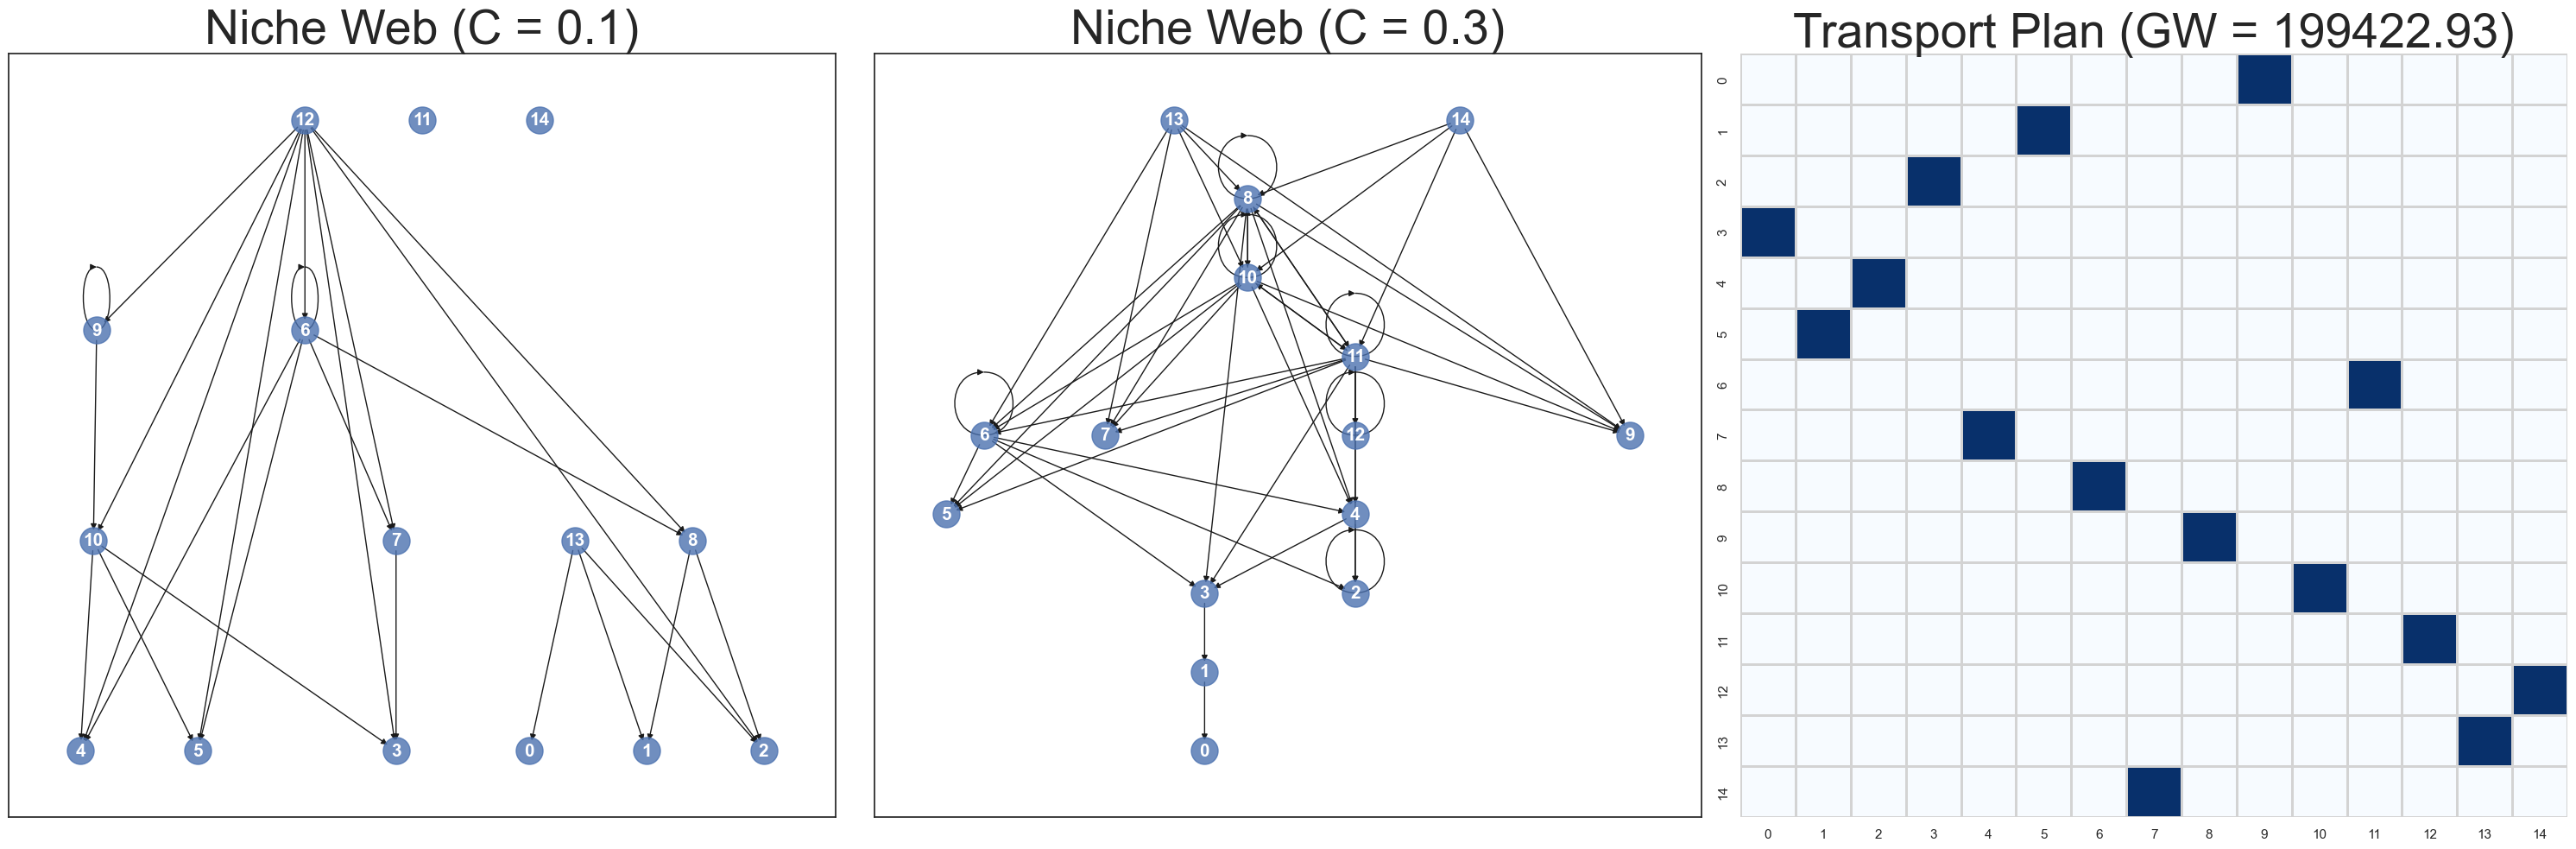

In [27]:
gw_dist, T = gw_dist_compute(niche_01, niche_03)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
pos1 = nx.nx_agraph.graphviz_layout(niche_01, prog="dot")
pos2 = nx.nx_agraph.graphviz_layout(niche_03, prog="dot")
show_network(niche_01, ax=ax[0], pos = pos1)
show_network(niche_03, ax=ax[1], pos = pos2)
sns.heatmap(T, cmap="Blues", ax=ax[2], linewidths=1, linecolor='lightgray', cbar=False)

ax[0].set_title("Niche Web (C = 0.1)", fontsize=40)
ax[1].set_title("Niche Web (C = 0.3)", fontsize=40)
ax[2].set_title(f"Transport Plan (GW = {gw_dist:.2f})", fontsize=40)
plt.tight_layout()

plt.savefig(f"{GENERATIVE_RES_DIR}/niche_graph_2.png", dpi=DPI, bbox_inches='tight')

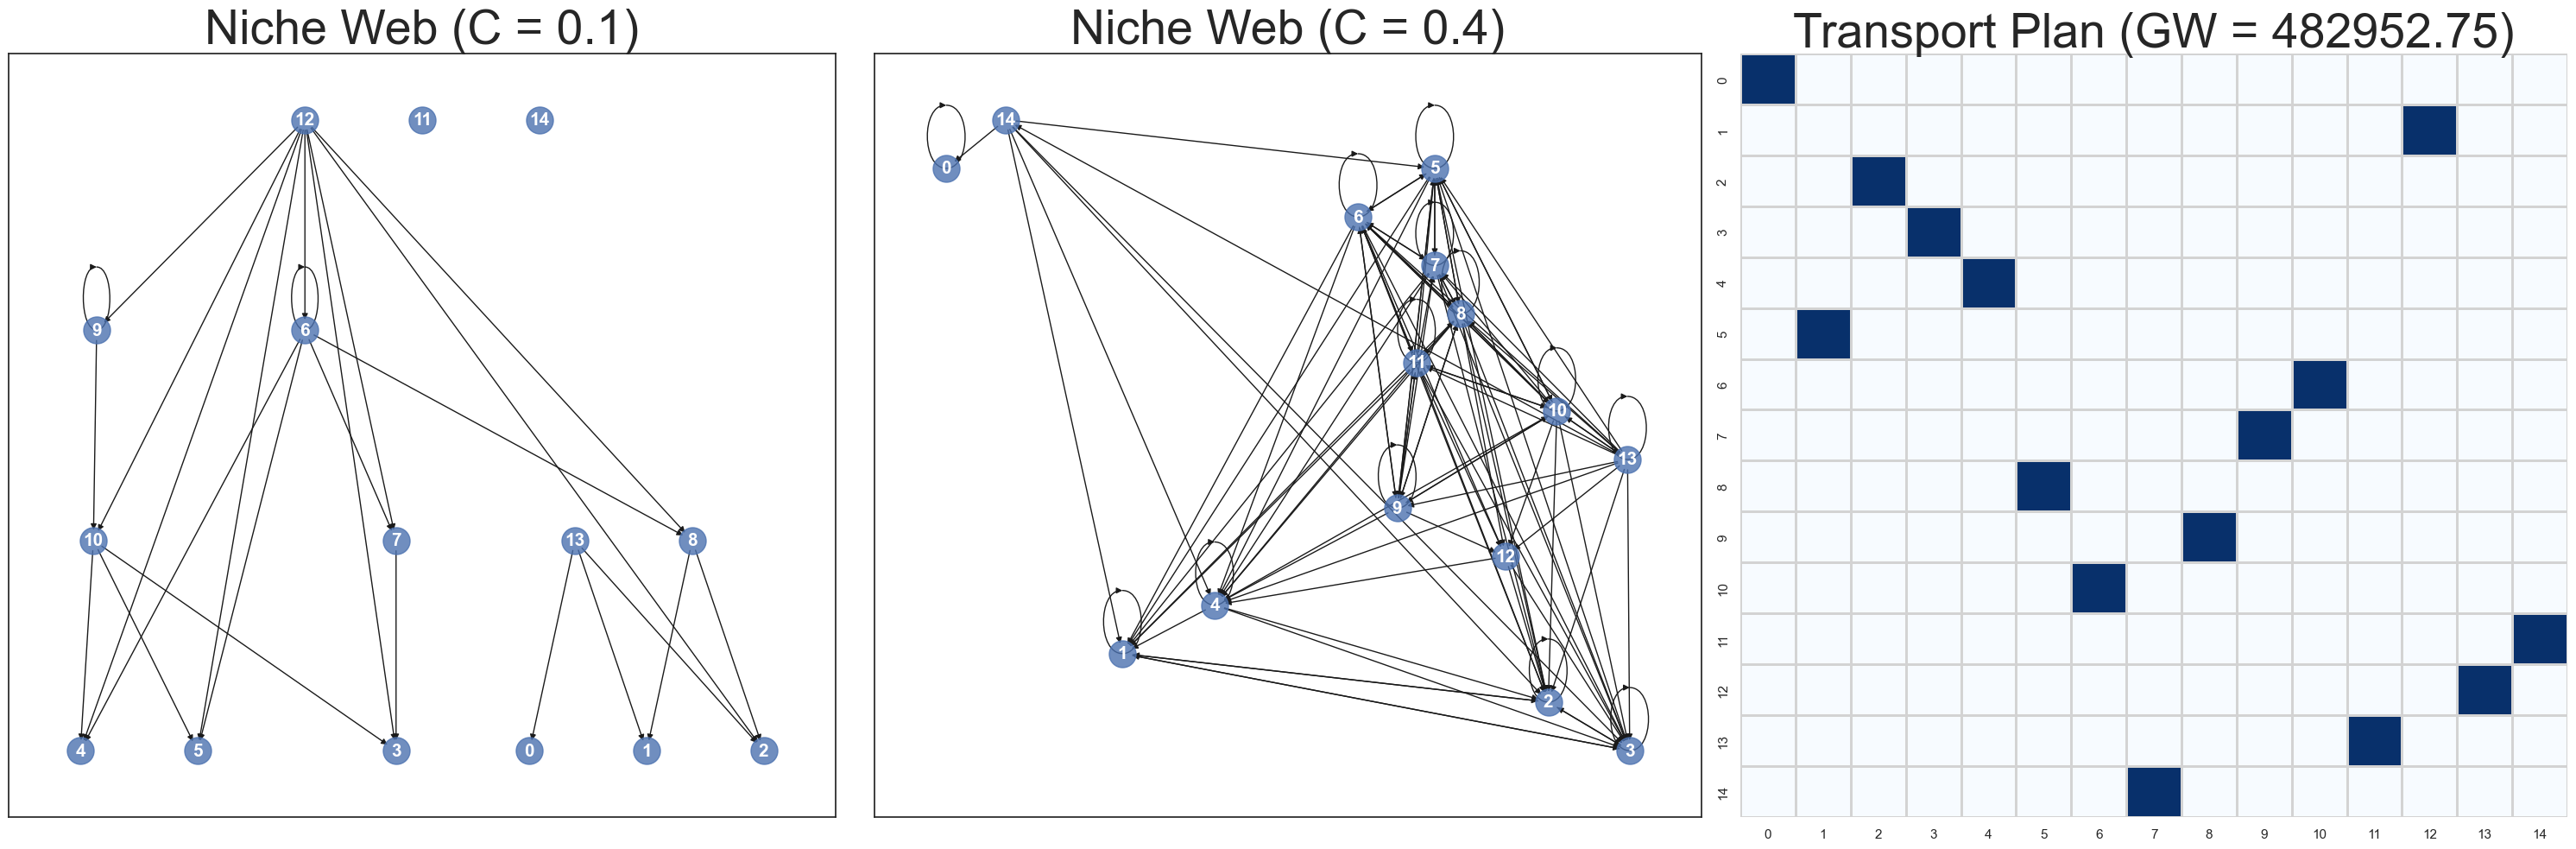

In [28]:
gw_dist, T = gw_dist_compute(niche_01, niche_04)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
pos1 = nx.nx_agraph.graphviz_layout(niche_01, prog="dot")
pos2 = nx.nx_agraph.graphviz_layout(niche_04, prog="dot")
show_network(niche_01, ax=ax[0], pos = pos1)
show_network(niche_04, ax=ax[1], pos = pos2)
sns.heatmap(T, cmap="Blues", ax=ax[2], linewidths=1, linecolor='lightgray', cbar=False)

ax[0].set_title("Niche Web (C = 0.1)", fontsize=40)
ax[1].set_title("Niche Web (C = 0.4)", fontsize=40)
ax[2].set_title(f"Transport Plan (GW = {gw_dist:.2f})", fontsize=40)
plt.tight_layout()

plt.savefig(f"{GENERATIVE_RES_DIR}/niche_graph_3.png", dpi=DPI, bbox_inches='tight')